In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yaml

from vae.vae_torch import VAE
from functions.data_cleaning import DataClean as dc
from functions.utilities import *
from functions.metrics import *
from functions.figure_plotting import FigurePlot as fp

In [2]:
sns.set_theme()
sns.set_style("ticks")

#Avant Garde palette
CB91_Brown = "#7d5a1b"
CB91_Brown_Gray = "#816b51"
CB91_Green = "#294013"
CB91_Light_Green = "#d8ffc4"
CB91_Red = "#84290d"

# Out of palette
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Yellow = "#dfc077"

Green_Grad = ["#d8ffc4", "#bbdfa7", "#9ebf89", "#81a06c", "#63804e", "#466031", 
              "#294013", "#24380f", "#1e310b", "#192908", "#132204", "#0e1a00"]

Red_Grad = ["#fff1e3", "#efc6b0", "#df9b7d", "#cf6f4a", "#bf4417", "#ab3b14",
            "#983210", "#84290d", "#70200a", "#5c1707", "#490e03", "#350500"]

Brown_Grad = ["#fffac3", "#efda9d", "#dfc077", "#cfa550",  "#bf8b2a", "#a97a24", 
              "#93681e", "#7d5718", "#684512", "#52340c", "#3c2206", "#261100"]

color_list = [CB91_Brown, CB91_Green, CB91_Light_Green, CB91_Red,
              CB91_Purple, CB91_Violet,  CB91_Yellow, CB91_Brown_Gray]

#A list of hex colours running between blue and purple
CB91_Grad_BP = ['#2cbdfe', '#2fb9fc', '#33b4fa', '#36b0f8',
                '#3aacf6', '#3da8f4', '#41a3f2', '#449ff0',
                '#489bee', '#4b97ec', '#4f92ea', '#528ee8',
                '#568ae6', '#5986e4', '#5c81e2', '#607de0',
                '#6379de', '#6775dc', '#6a70da', '#6e6cd8',
                '#7168d7', '#7564d5', '#785fd3', '#7c5bd1',
                '#7f57cf', '#8353cd', '#864ecb', '#894ac9',
                '#8d46c7', '#9042c5', '#943dc3', '#9739c1',
                '#9b35bf', '#9e31bd', '#a22cbb', '#a528b9',
                '#a924b7', '#ac20b5', '#b01bb3', '#b317b1']

sns.set(font="Verdana",
        rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False})
 
custom_colors = color_list
sns.set_palette(sns.color_palette(color_list, 8))

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

In [3]:
torch.manual_seed(42)

In [4]:
reload = True  # Load and use pretrained model if True
select_model = 3  # latent 0=15 1=30 2=50 3=100
save_figures = False
save_curves = False
causal_model = False  # If preparing data with 199 features only

In [5]:
model_configuration_file = "configurations/torch_vae.yaml"
preprocessing_configuration_file = "configurations/categorical_preprocessing_configuration.yaml"
plotting_configuration_file = "configurations/print.yaml"
data_filename = "data/original_preprocessed.csv"
# data_filename = "data/FI_2013p_EUSILC.csv"
draw = fp(plotting_configuration_file)

In [6]:
with open(model_configuration_file, 'r') as file:
    cfg = yaml.safe_load(file)
vae_cfg = cfg["model"]
model = cfg["globals"]["name"]
model_name = cfg["globals"]["model_name"][select_model]
model_type = cfg["globals"]["model_type"]

In [7]:
begin = time.time()
data = dc(datafile=data_filename,
          prepared=True,
          configuration_file=preprocessing_configuration_file,
          )
duration = time.time() - begin
print(duration)

Using provided preprocessed file data/original_preprocessed.csv
0.13742876052856445


In [8]:
df = data.get_data()
feature_dimension = df.shape[1]

In [9]:
number_epochs = int(vae_cfg["epochs"][select_model])
learning_rate = float(vae_cfg["learning_rate"][0])
loss_fn = nn.BCELoss(reduction="sum")
batch_size = vae_cfg["batch_size"]
beta_vae = float(vae_cfg["beta"])
optimiser_name=vae_cfg["optimiser_name"]

In [10]:
if reload:
    model_collection = []   
    for lat in vae_cfg["latent_dimensions"]:
        mod = VAE(feature_dimension, lat)
        opt = optim.RMSprop(mod.parameters(), lr=learning_rate)
        vae_dict = torch.load(vae_cfg["model_dict_file_" + str(lat)])
        opt_dict = torch.load(vae_cfg["opt_dict_file_" + str(lat)])
        mod.load_state_dict(vae_dict)
        opt.load_state_dict(opt_dict)
        model_collection.append((lat, mod))

In [11]:
if reload:
    synthetic_collection = []
    for lat, mod in model_collection:
        torch_s = get_synthetic(mod.decoder, df.shape[0], int(lat))
        dt = data.get_synthetic(torch_s.detach().numpy(), df.columns)
        synthetic_collection.append(dt) 

Do detect 123 difference!!!
Old data shape (19291, 107)
New dataframe shape (19291, 123)
Returned dataframe has shape (19291, 230)
Do detect 84 difference!!!
Old data shape (19291, 146)
New dataframe shape (19291, 84)
Returned dataframe has shape (19291, 230)
Do detect 26 difference!!!
Old data shape (19291, 204)
New dataframe shape (19291, 26)
Returned dataframe has shape (19291, 230)
Do detect 6 difference!!!
Old data shape (19291, 224)
New dataframe shape (19291, 6)
Returned dataframe has shape (19291, 230)


In [12]:
if causal_model:
    df = data.get_data_causal()
else:
    df = data.get_data()

In [13]:
torch_data = torch.tensor(df.values, dtype=torch.float32)

In [14]:
latent_dimension = vae_cfg["latent_dimensions"][select_model]

In [15]:
model_vae = VAE(feature_dimension, latent_dimension)
optimiser = optim.RMSprop(model_vae.parameters(), lr=learning_rate)
if not reload:
    model_vae.train()

In [16]:
if reload:
    vae_dict = torch.load(vae_cfg["model_dict_file_" + str(latent_dimension)])
    opt_dict = torch.load(vae_cfg["opt_dict_file_" + str(latent_dimension)])
    model_vae.load_state_dict(vae_dict)
    optimiser.load_state_dict(opt_dict)

In [17]:
def kl_loss(mu, log_var): # std = sigma ** 2 log_var = log(sigma ** 2)
    loss_kl = - 0.5 * torch.sum(1 + log_var - torch.exp(log_var) - mu ** 2)
    return loss_kl

In [18]:
if not reload:
    begin = time.time()

In [19]:
if not reload:
    collect_loss = []
    for epoch in range(number_epochs):
        loader = DataLoader(torch_data, batch_size=batch_size, shuffle=True)
        for batch_idx, (real) in enumerate(loader):
            #batch_size = real.shape[0]
            replica, z_mean, z_sigma = model_vae(real)
            reconstruction_loss = loss_fn(replica, real)
            kl = beta_vae * (kl_loss(z_mean, z_sigma) / real.shape[1])
            loss = reconstruction_loss + kl
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            if batch_idx % 50 == 0 and batch_idx > 0:
                print(f"Epoch [{epoch} / {number_epochs}] \ "
                      f"KL Loss: {kl:4f}, Rep Loss: {reconstruction_loss:.4f}")
                collect_loss.append((kl, reconstruction_loss))

In [20]:
if not reload:
    duration = time.time() - begin
    print(duration)

In [21]:
fake = torch.randn(df.shape[0], latent_dimension)
torch_s = model_vae.decoder(fake)
torch_df = torch_s.detach().numpy()

In [22]:
torch_s.shape

torch.Size([19291, 230])

In [23]:
if causal_model:
    df_s = data.get_synthetic_causal(torch_df, columns=df.columns)
else:
    df_s = data.get_synthetic(torch_df, columns=df.columns)

Do detect 7 difference!!!
Old data shape (19291, 223)
New dataframe shape (19291, 7)
Returned dataframe has shape (19291, 230)


# Plot Univariate Marginals

In [24]:
combine = pd.concat([df.mean(), df_s.mean()], axis=1)
vae_column = "VAE-" + str(latent_dimension)
combine.columns = ["Original", vae_column]

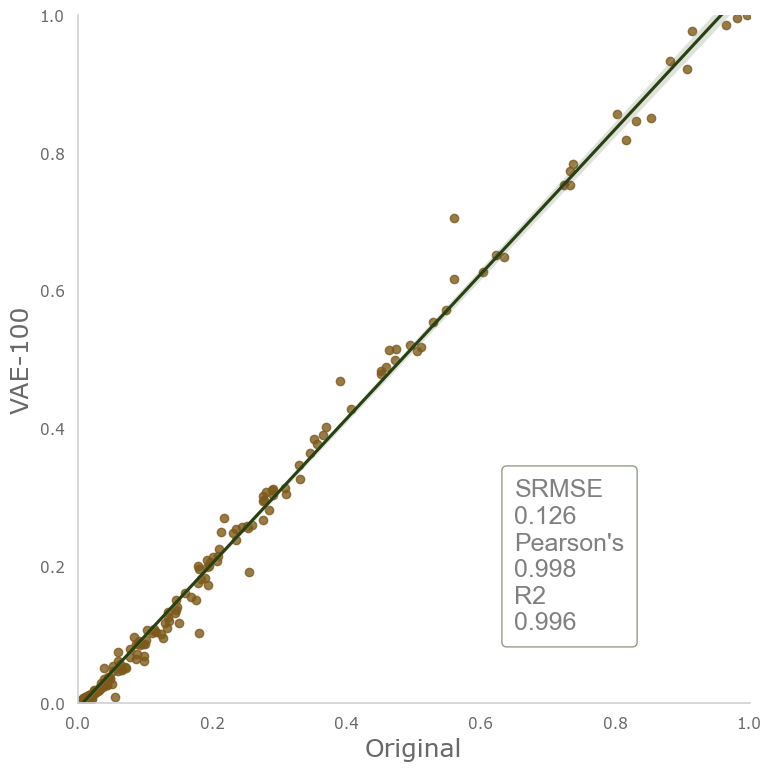

In [25]:
draw.plot_compare(data=combine,
                  title="compare",
                  model_type=("categorical_" + str(number_epochs) + 
                              "_features_" + str(feature_dimension) + 
                              "_lat_" + str(latent_dimension)),
                  model=model,
                  model_name=model_name,
                  save=save_curves
                  )

In [26]:
save_model_name = ("models/vae/betavae_lr_" + str(learning_rate) +
                  "_epochs_" + str(number_epochs) + 
                  "_batch_" + str(batch_size) +
                  "_leaky_02" +
                  "_beta_" + str(beta_vae) +
                  "_feature_dim_" + str(feature_dimension) +
                   "_lat_dim_" + str(latent_dimension) +
                  "_optimiser_" + optimiser_name + ".pth")

save_opt_name = ("models/vae/" + optimiser_name + 
                 "_lr_" + str(learning_rate) +
                 "_epochs_" + str(number_epochs) +
                 "_feature_dim_" + str(feature_dimension) +
                 "_lat_dim_" + str(latent_dimension) + ".pth")

In [27]:
if not reload:
    # MUST be saved as dictionaries
    torch.save(model_vae.state_dict(), save_model_name)
    torch.save(optimiser.state_dict(), save_opt_name)

In [28]:
if not reload:
    x = []
    y = []
    for tup in collect_loss:
        x.append(tup[0].detach().numpy())
        y.append(tup[1].detach().numpy())

In [29]:
if not reload:
    plt.plot(y[12::1], label="reconstruction-loss")
    plt.xlabel('Epochs')
    plt.ylabel('Reconstruction Loss')
    plt.legend()
    if save_curves:
        plt.savefig("figures/vae/Reconstruction_loss_" + 
                    str(number_epochs) +
                    "_features_" + str(feature_dimension) +
                    "_lat_" + 
                    str(latent_dimension) + ".png", dpi=200)
    plt.show()

In [30]:
if not reload:
    plt.plot(x[24::1], label="kl-loss")
    plt.xlabel('Epochs')
    plt.ylabel('KL-Loss')
    plt.legend()
    
    if save_curves:
        plt.savefig("figures/vae/KL_loss_" + str(number_epochs) + 
                    "_features_" + str(feature_dimension) +
                    "_lat_" +
                    str(latent_dimension) + ".png", dpi=200)
    plt.show()

In [31]:
df_o_cat = data.get_data_recategorised()
df_s_cat = data.get_synthetic_recategorised(torch_s.detach().numpy(), columns=df.columns)

# Plot Bland-Altman on Univariate One-Hot-Encoded Variables

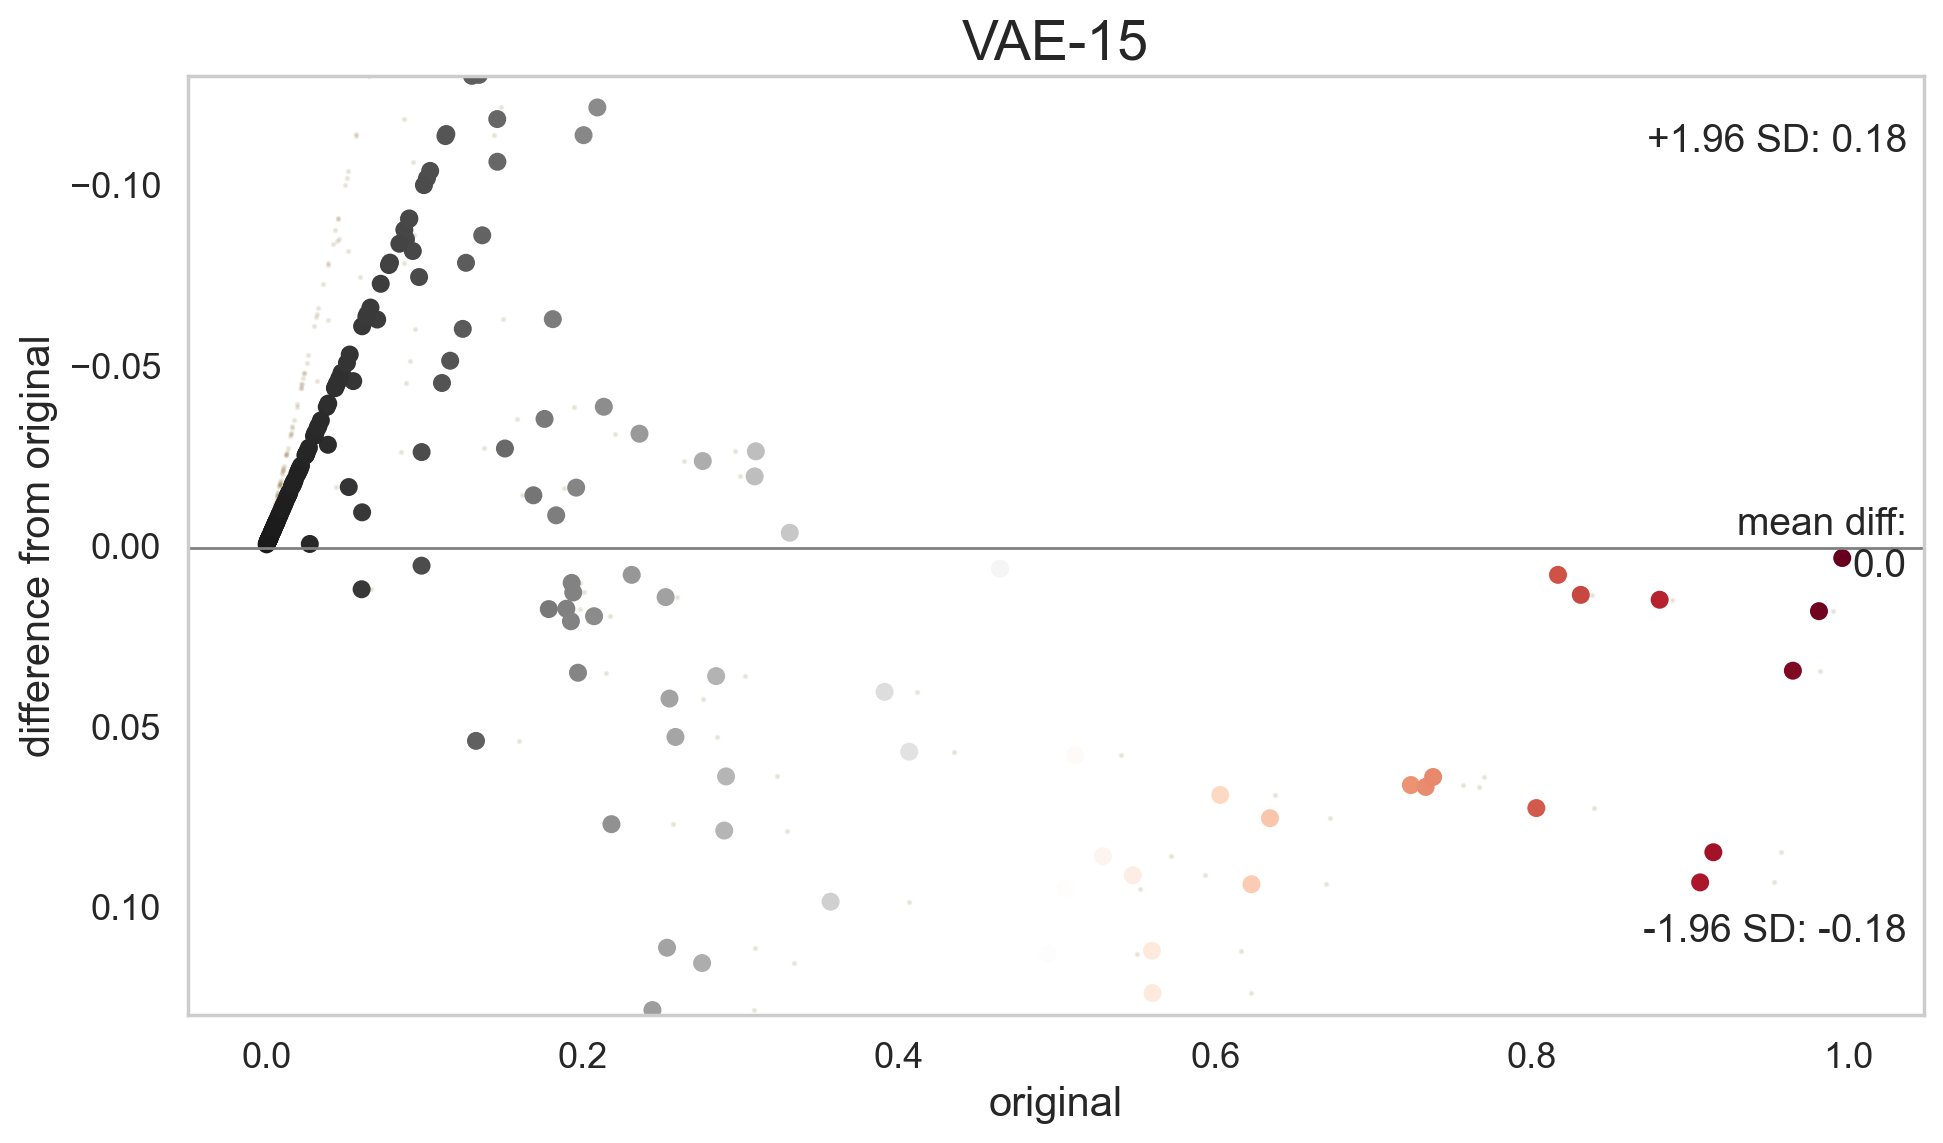

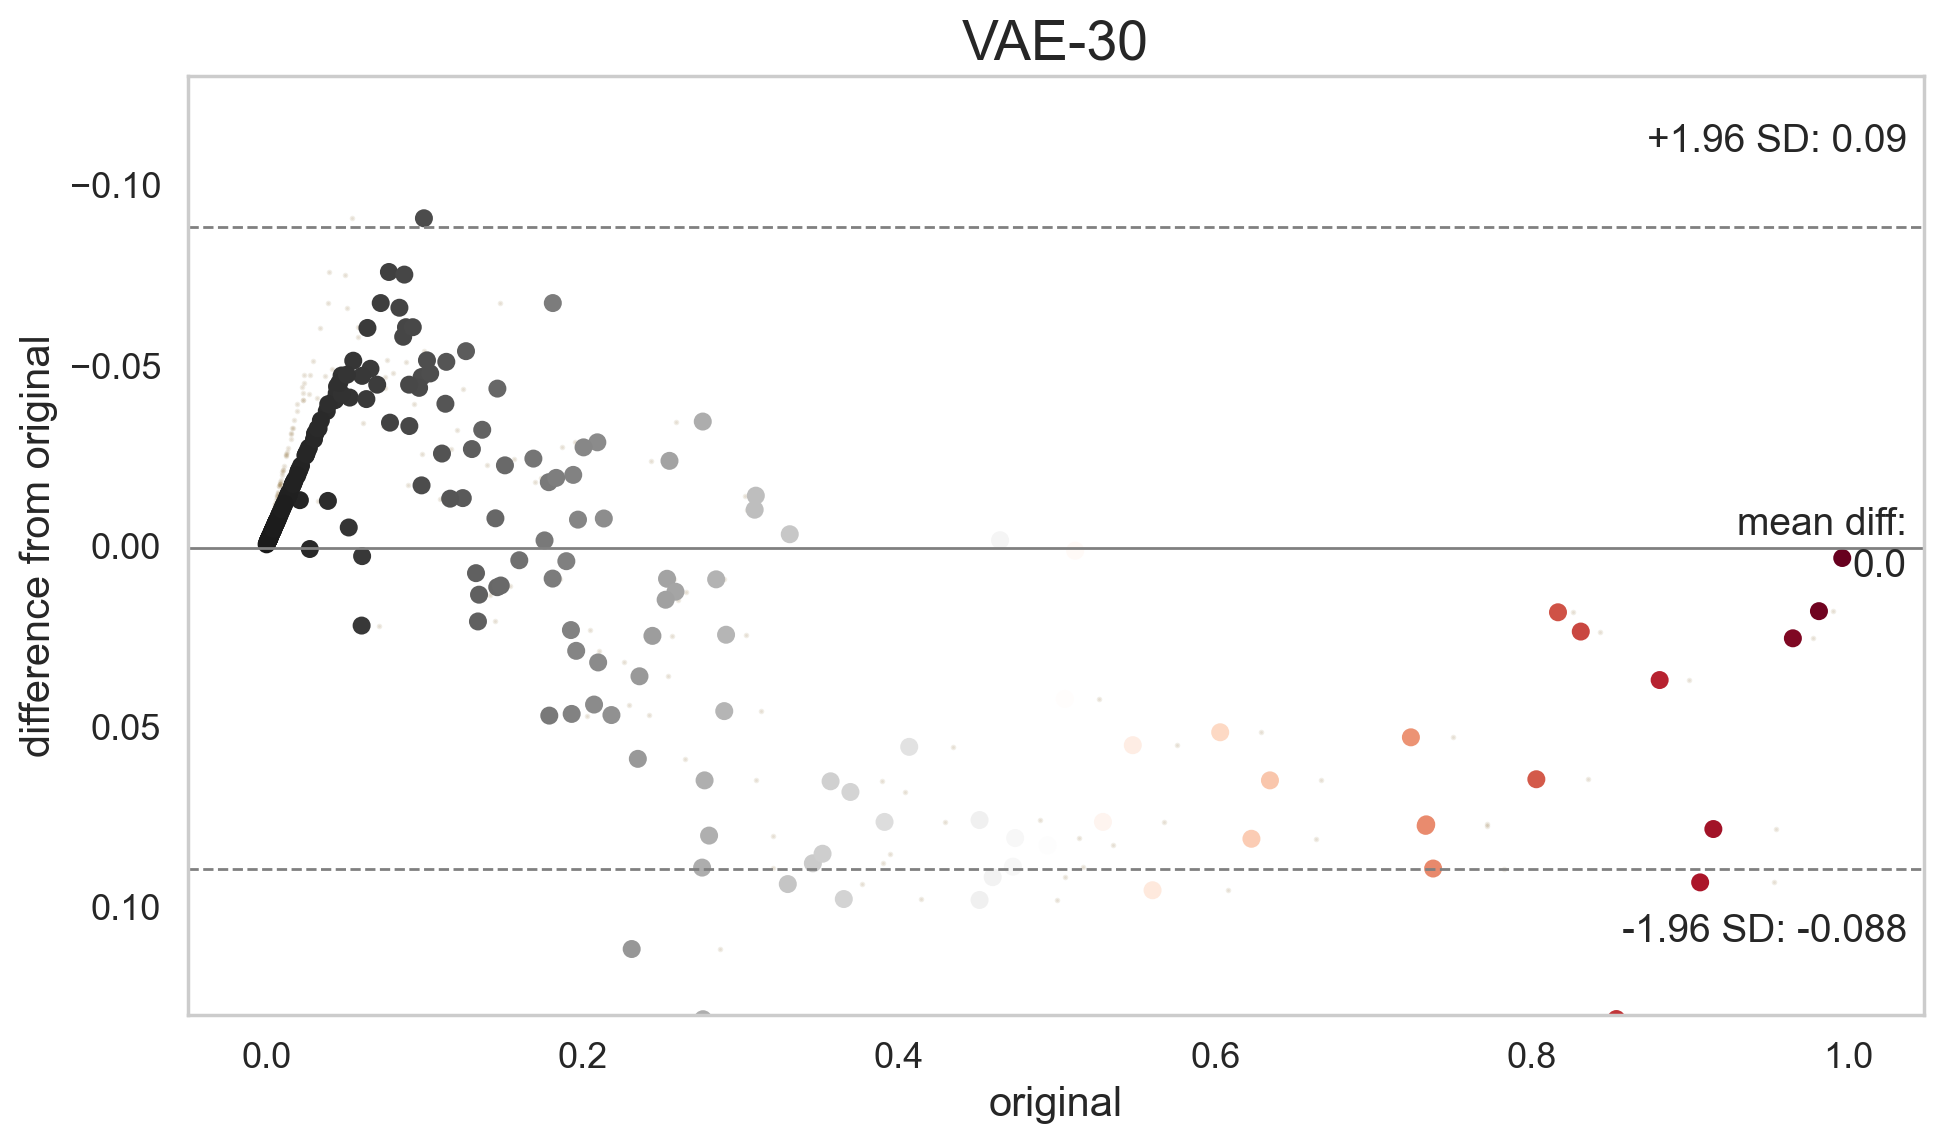

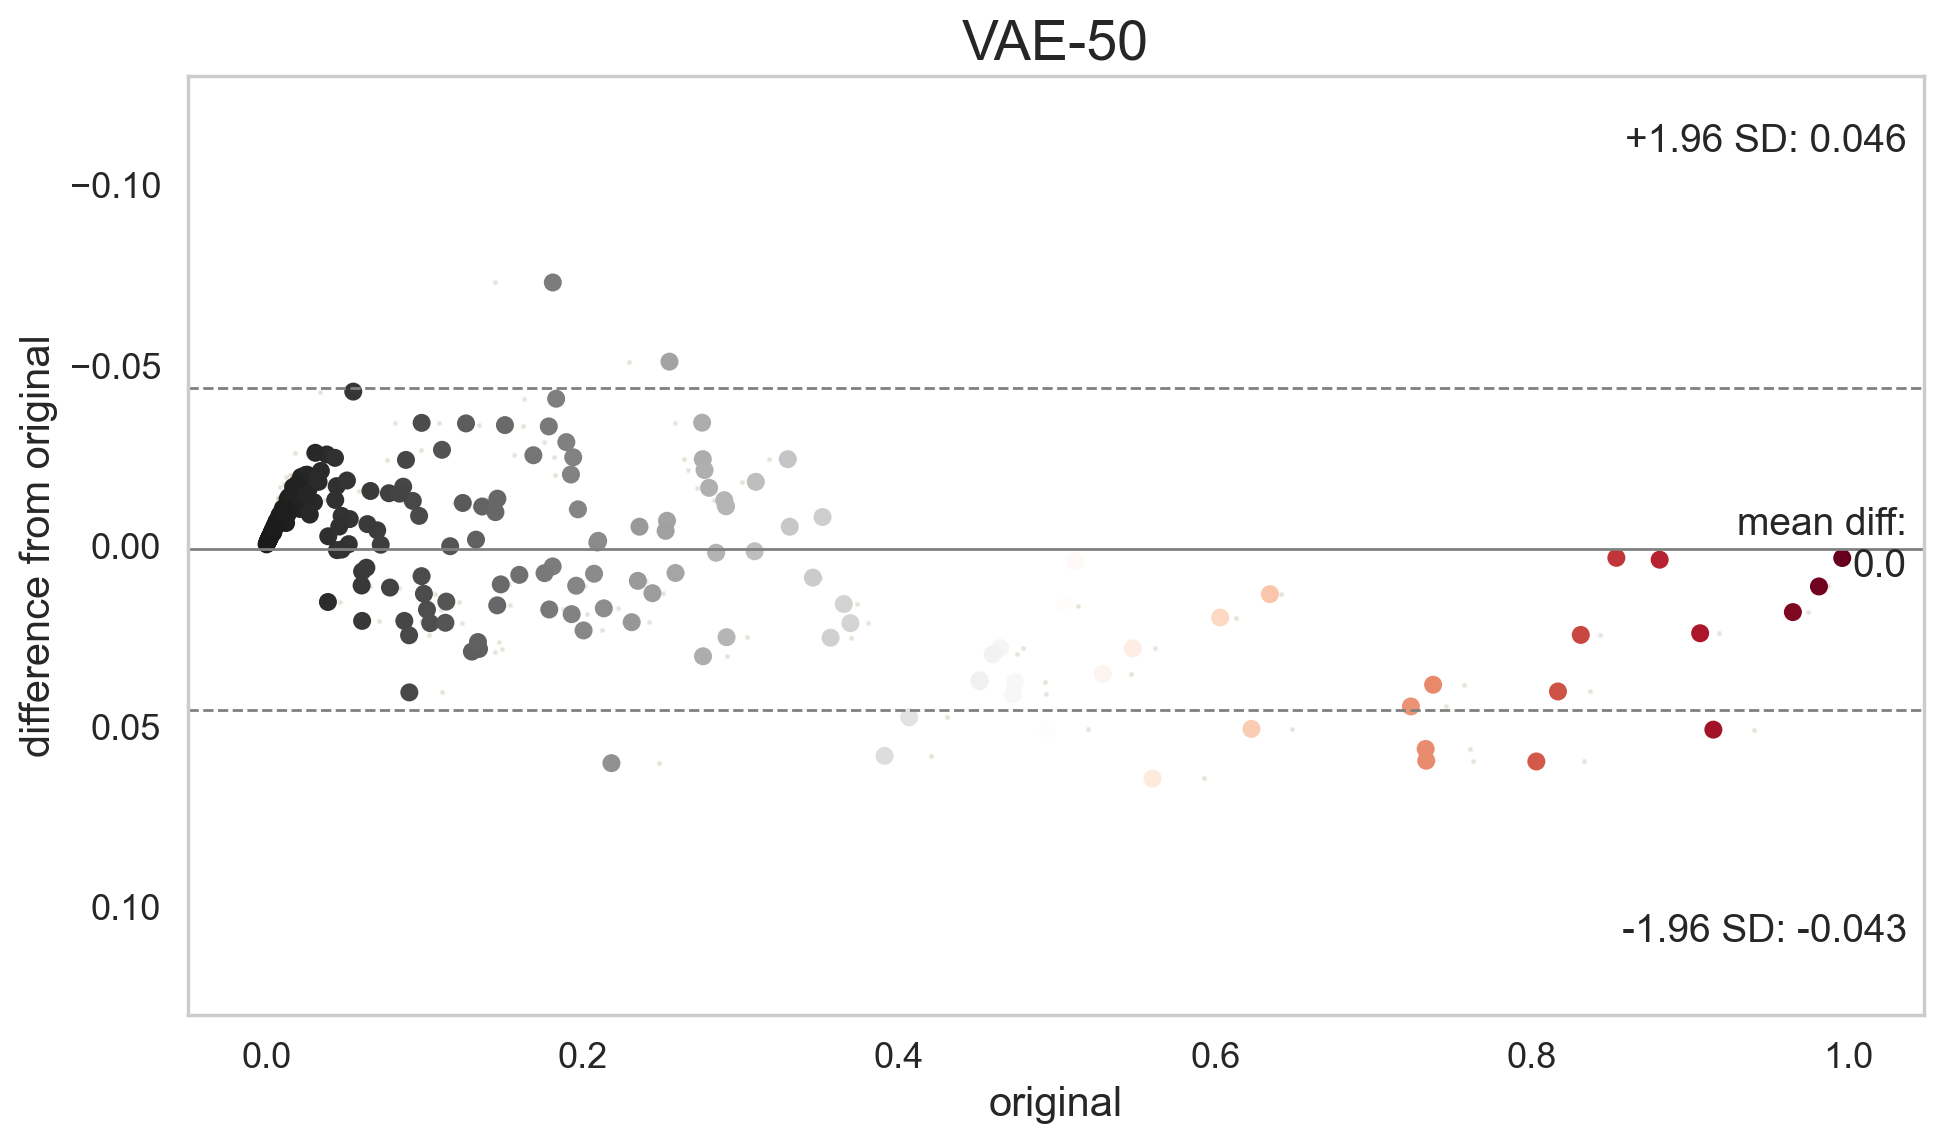

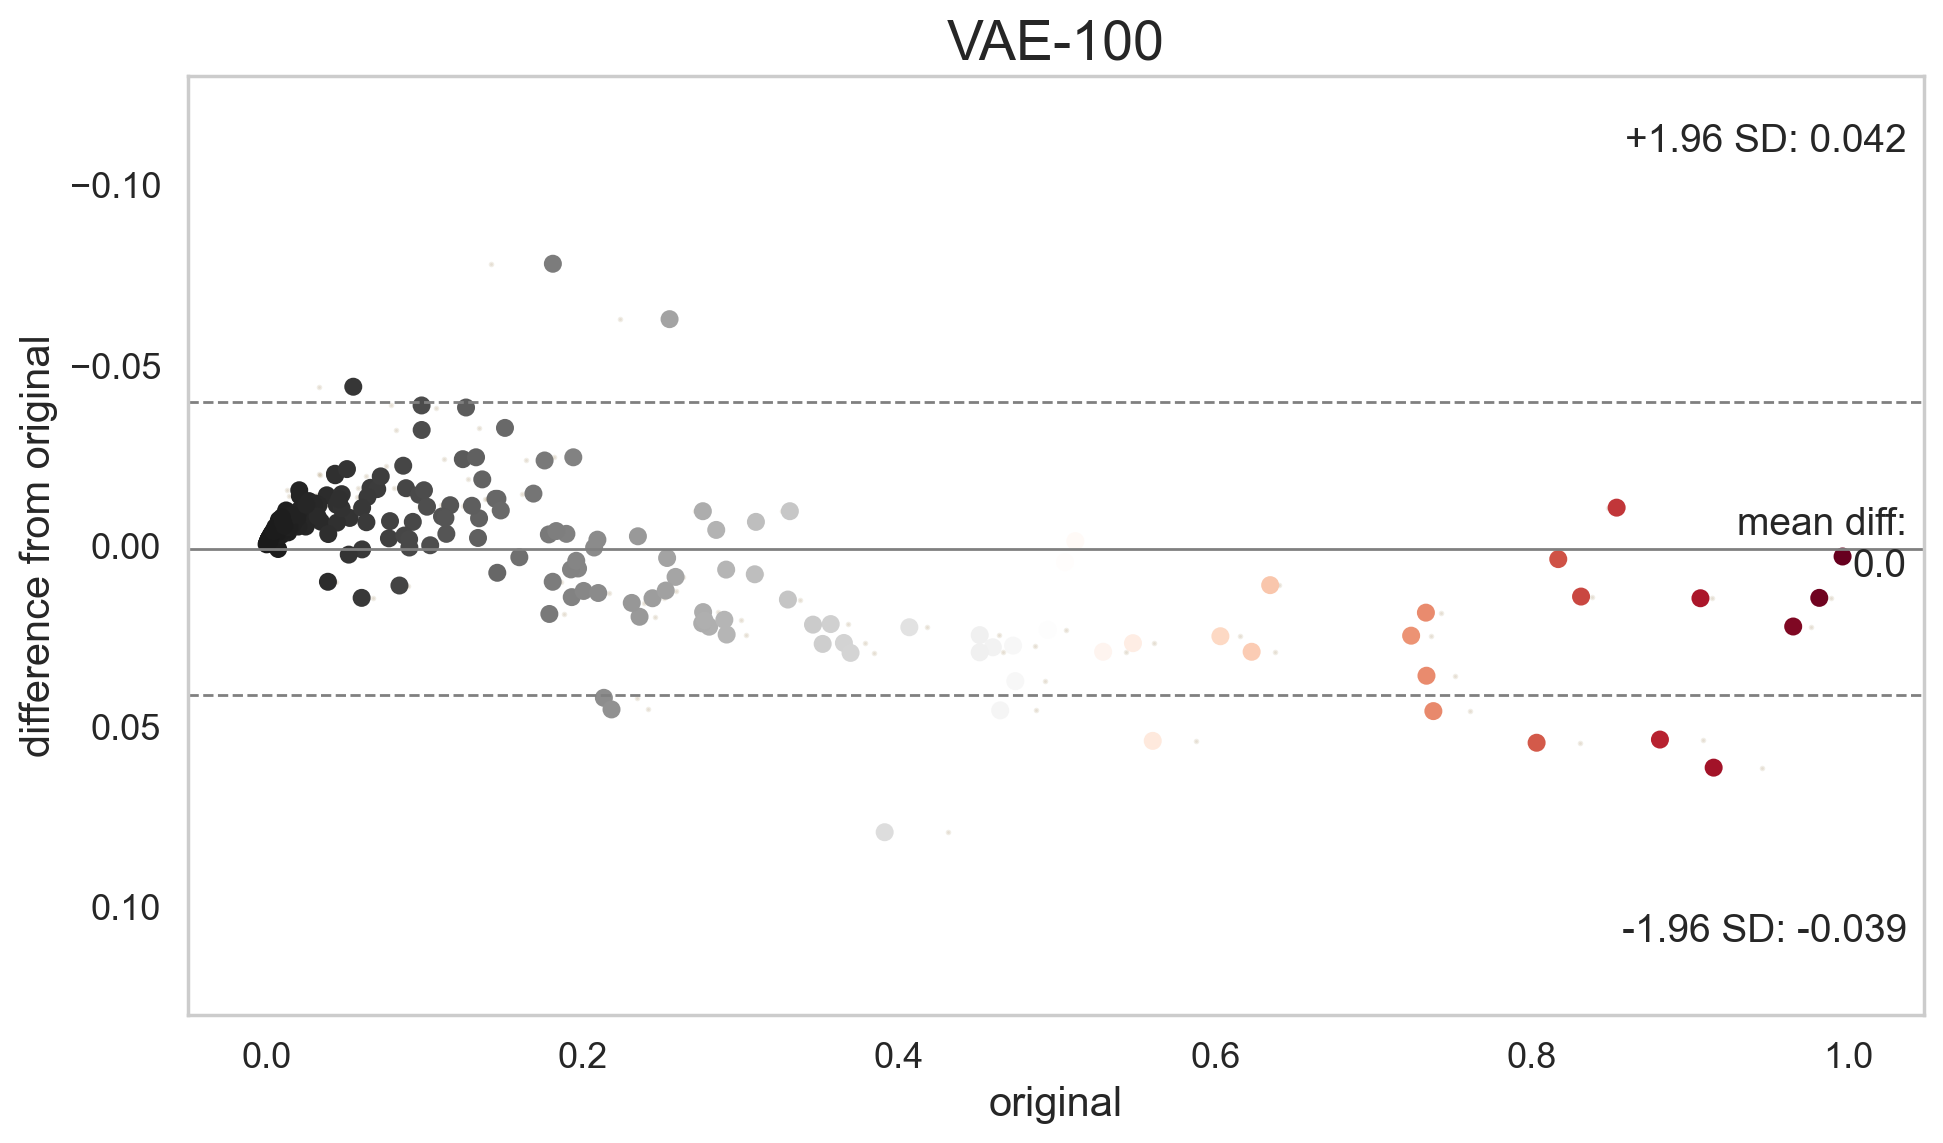

In [32]:
if reload:
    for i, mod in enumerate(model_collection):
        draw.color_bland_altman(df,
                                synthetic_collection[i],
                                title="VAE-" + str(mod[0]),
                                model=model,  # Directory!!! --> figures/[model]/
                                model_type=model_type,
                                model_name=model_name,
                                difference_from="original",
                                save=save_curves
                                )

# Plot Box Plots on Categoricals

<Figure size 640x480 with 0 Axes>

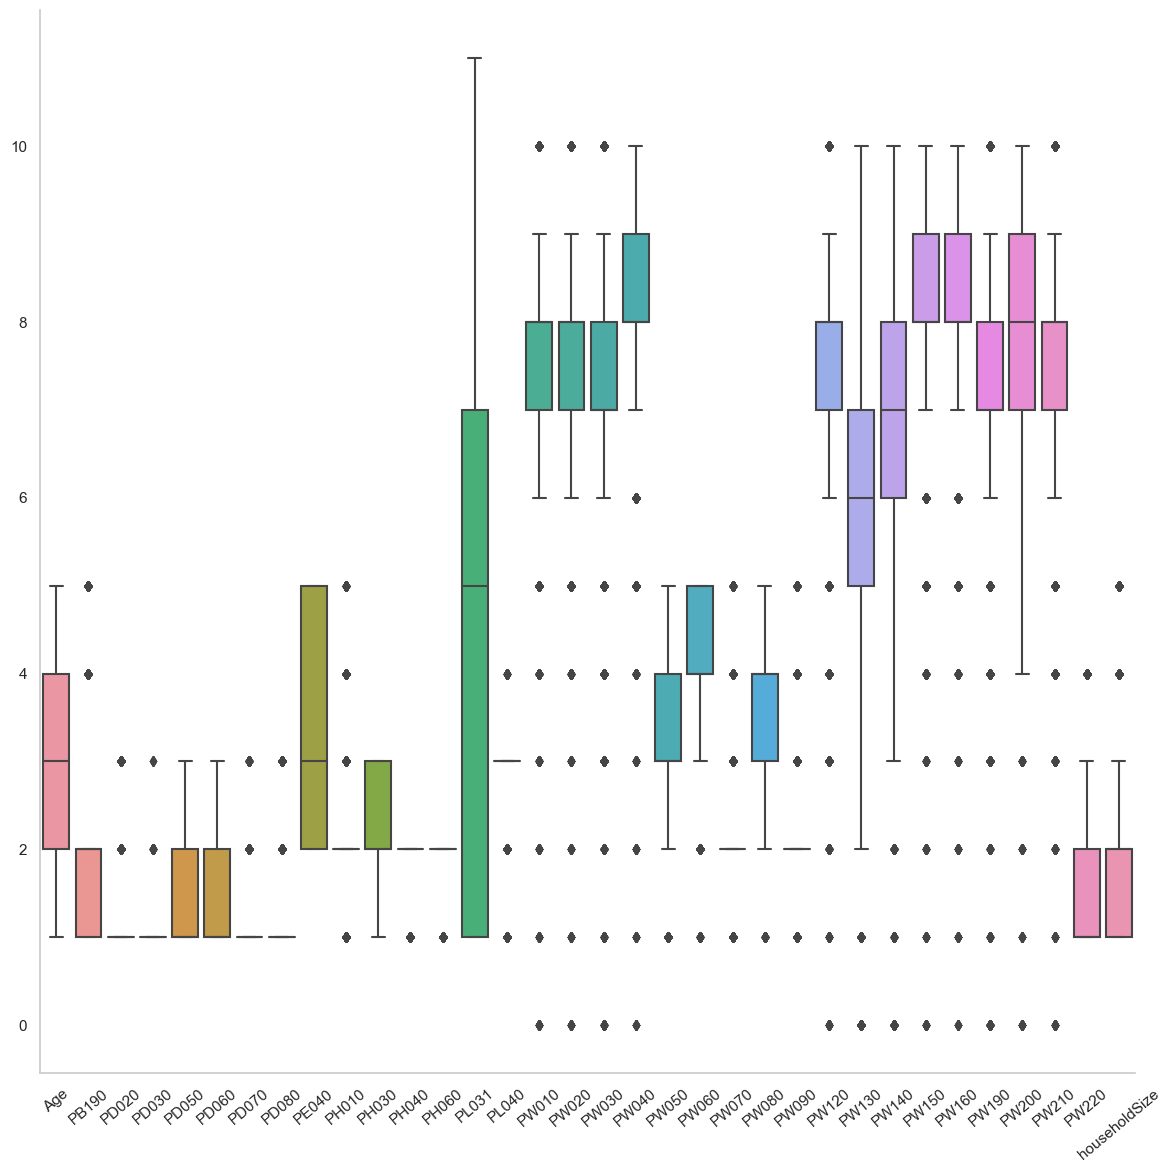

<Figure size 640x480 with 0 Axes>

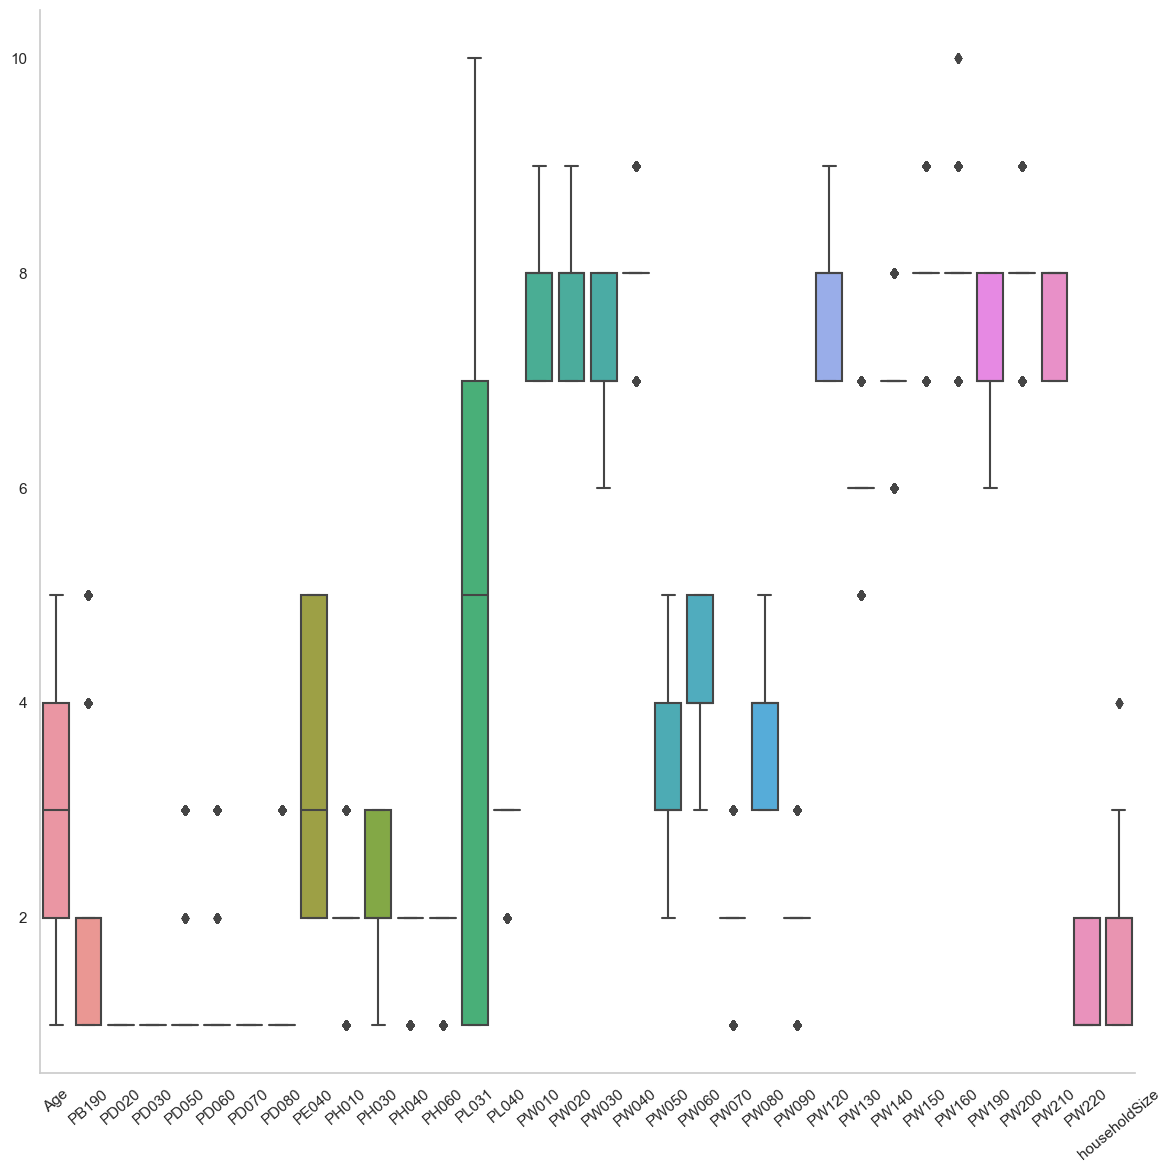

<Figure size 640x480 with 0 Axes>

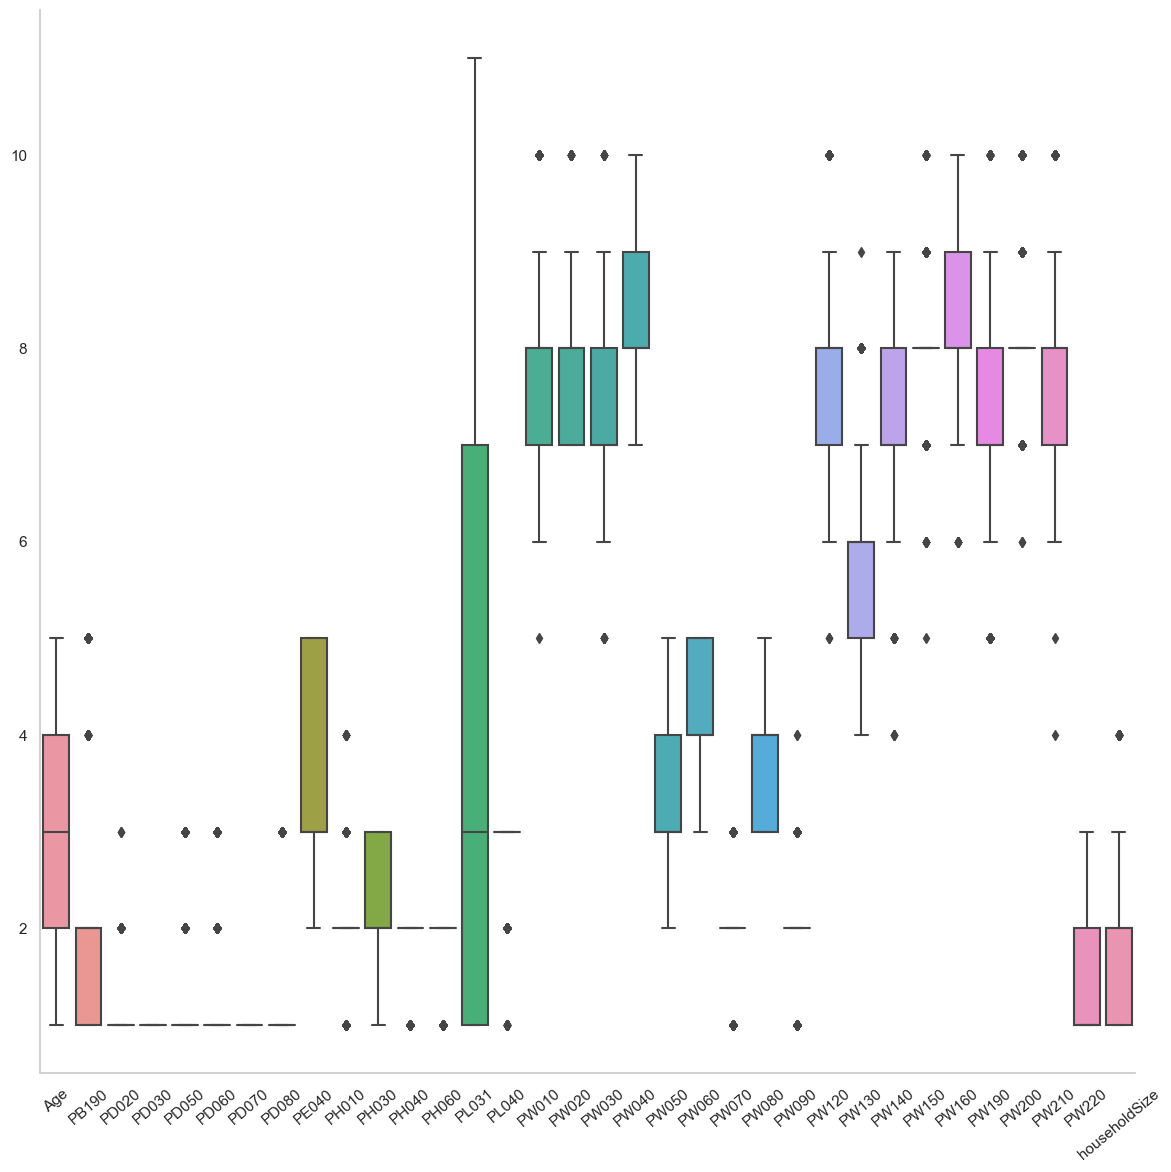

<Figure size 640x480 with 0 Axes>

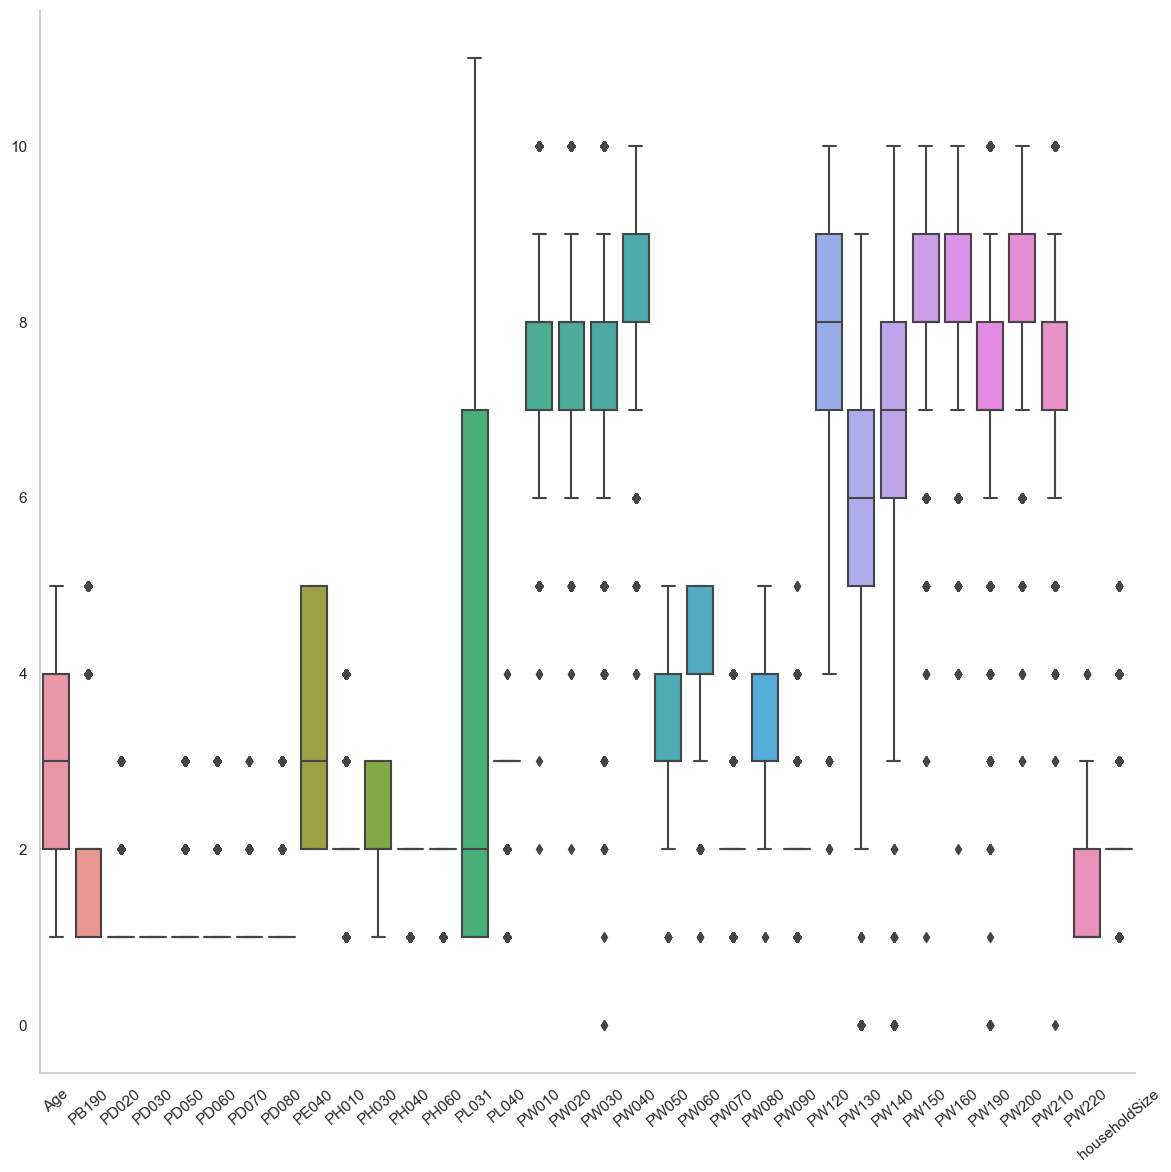

<Figure size 640x480 with 0 Axes>

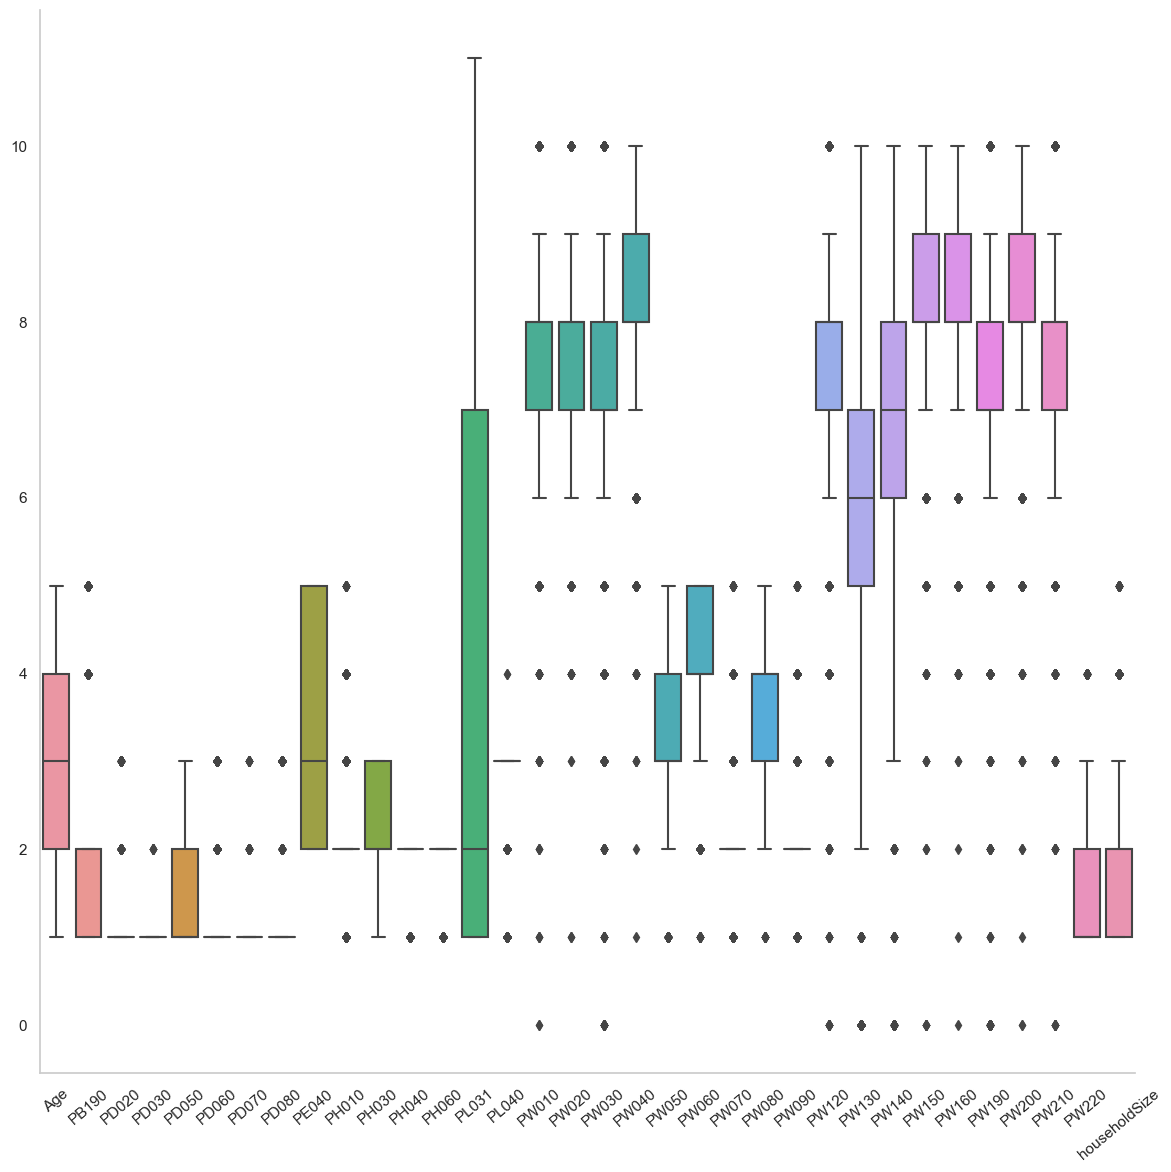

In [33]:
if reload:
    d_o_cat = data.get_data_recategorised()
    d_o_cat = d_o_cat.drop(data.binary, axis=1)
    draw.plot_catplot(d_o_cat,
                  title="Original-" + str(mod[0]),
                  model=model,  # Directory!!! --> figures/[model]/
                  model_type=model_type,
                  model_name=model_name,
                  save=save_curves
                  )
    for i, mod in enumerate(model_collection):
        d_cat = data.get_synthetic_recategorised(synthetic_collection[i], df.columns)
        d_cat = d_cat.drop(data.binary, axis=1)
        draw.plot_catplot(d_cat,
                          title="VAE-" + str(mod[0]),
                          model=model,  # Directory!!! --> figures/[model]/
                          model_type=model_type,
                          model_name=model_name,
                          save=save_curves
                          )

In [34]:
fraction_o = df.mean(axis=0)
binary_o = fraction_o.values.reshape(-1, 1) * fraction_o.values.reshape(-1, 1).T
binary_o = binary_o[~np.eye(binary_o.shape[0],dtype=bool)].reshape(binary_o.shape[0],-1)  # Remove diagonal
fraction_synthetic = []
for s in synthetic_collection:
    frac = s[df.columns].mean(axis=0).values.reshape(-1, 1)
    binary = frac * frac.T
    binary = binary[~np.eye(binary.shape[0],dtype=bool)].reshape(binary.shape[0],-1)
    fraction_synthetic.append((frac, binary))

# Plot Bivariate on Marginals

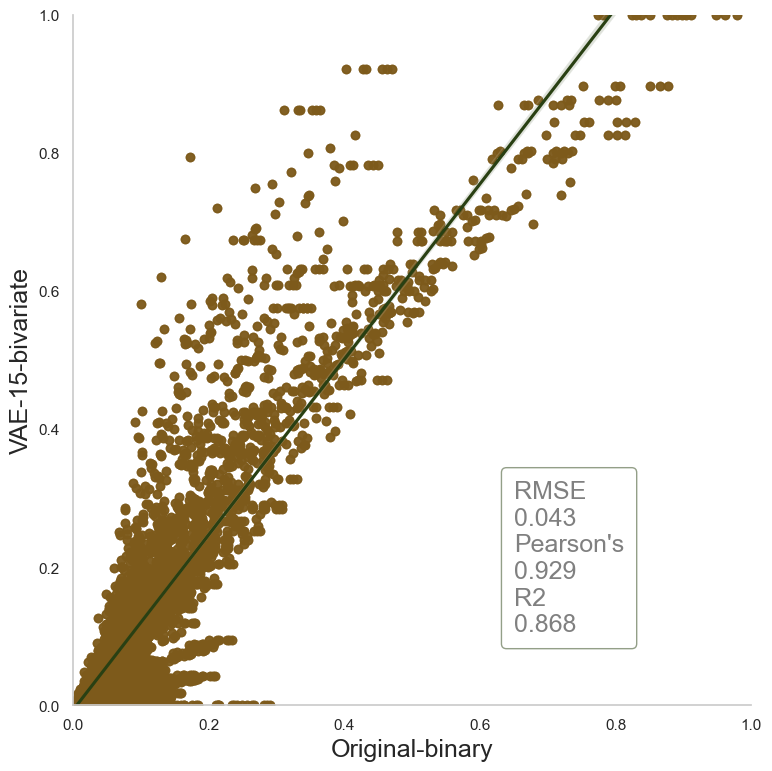

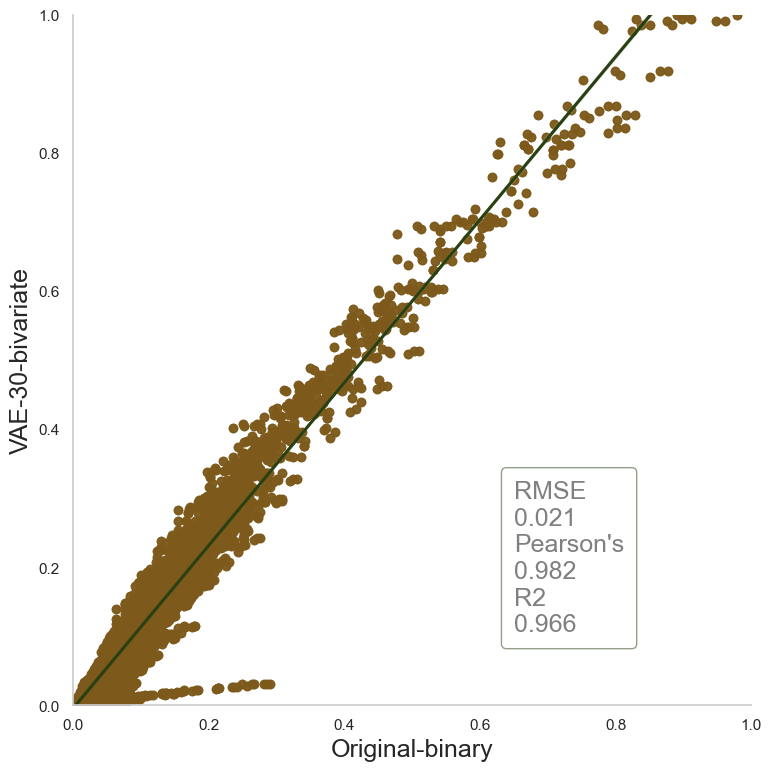

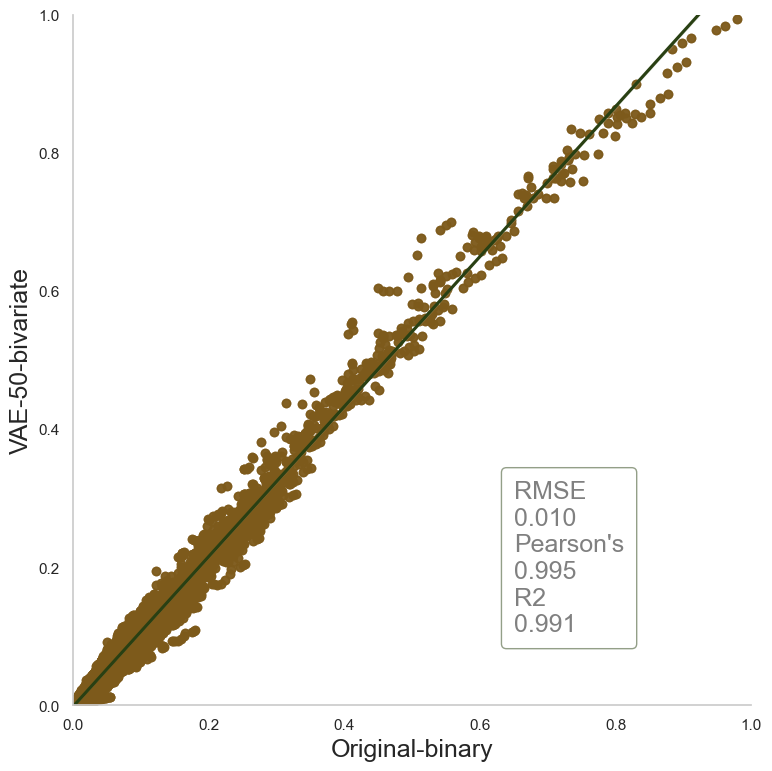

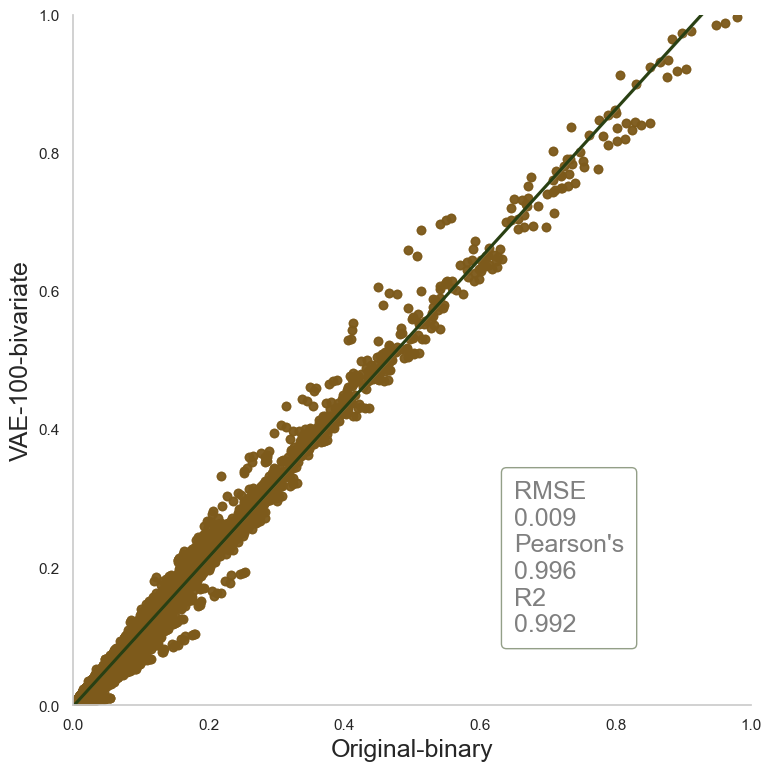

In [35]:
# Plot binary correlation calculated by cross-product - where the univariate diagonal is removed,
# keeping only the bivariate connections 
for (_, bi), lat  in zip(fraction_synthetic, vae_cfg["latent_dimensions"]):
    combine = pd.concat([pd.DataFrame(binary_o.flatten()), pd.DataFrame(bi.flatten())], axis=1)
    combine.columns = ["Original-binary", "VAE-" + str(lat) + "-bivariate"]
    draw.plot_compare(data=combine,
                  title="compare",
                  model_type="bivariate_fin_" + "_lat_" + str(lat),
                  model=model,
                  model_name=model_name,
                  save=save_curves,
                  norm_rmse=False
                  )

<Figure size 640x480 with 0 Axes>

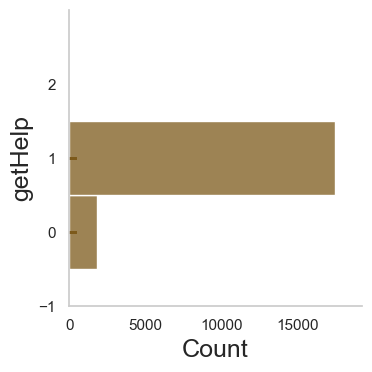

<Figure size 640x480 with 0 Axes>

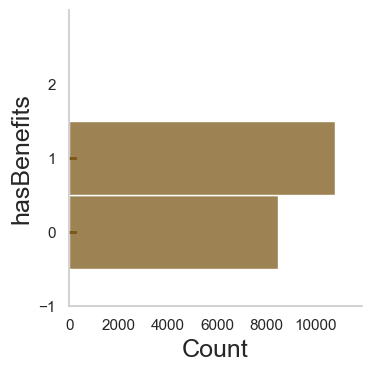

<Figure size 640x480 with 0 Axes>

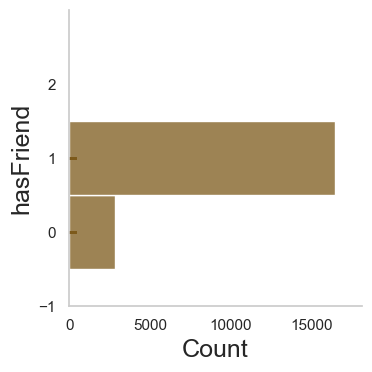

<Figure size 640x480 with 0 Axes>

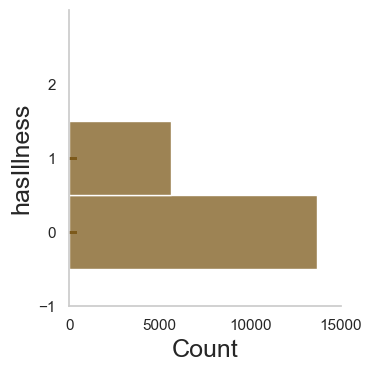

<Figure size 640x480 with 0 Axes>

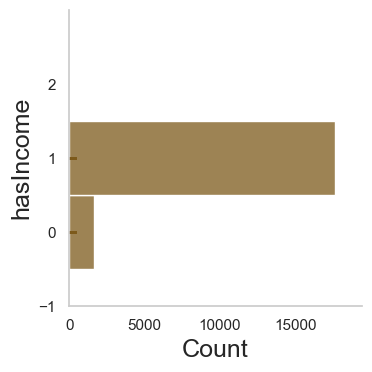

<Figure size 640x480 with 0 Axes>

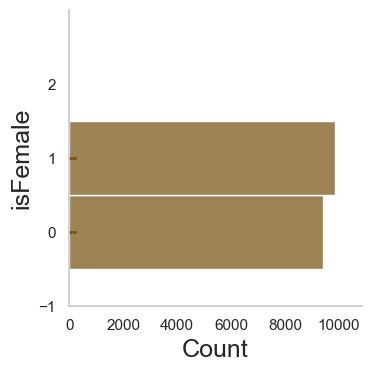

<Figure size 640x480 with 0 Axes>

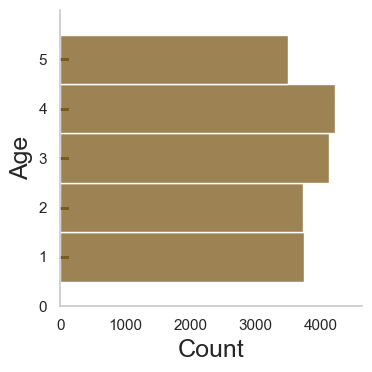

<Figure size 640x480 with 0 Axes>

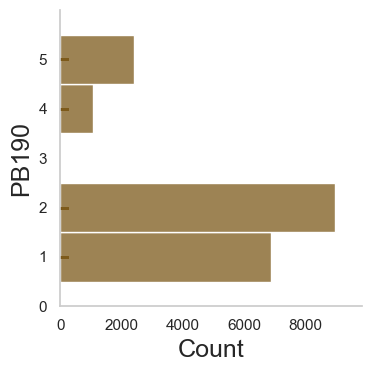

<Figure size 640x480 with 0 Axes>

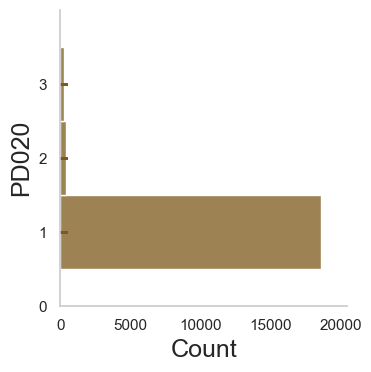

<Figure size 640x480 with 0 Axes>

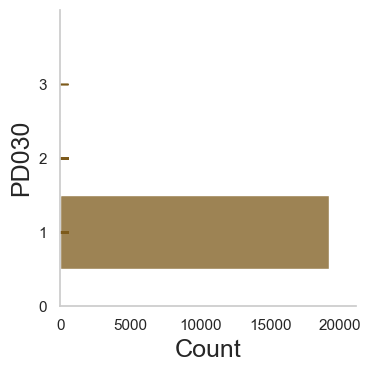

<Figure size 640x480 with 0 Axes>

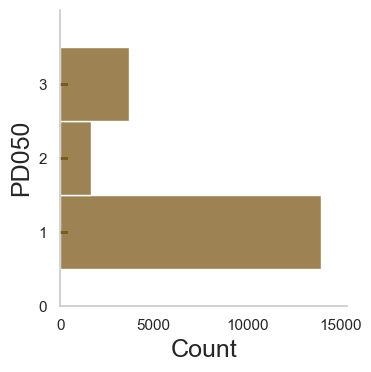

<Figure size 640x480 with 0 Axes>

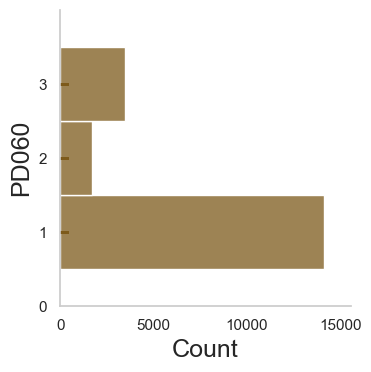

<Figure size 640x480 with 0 Axes>

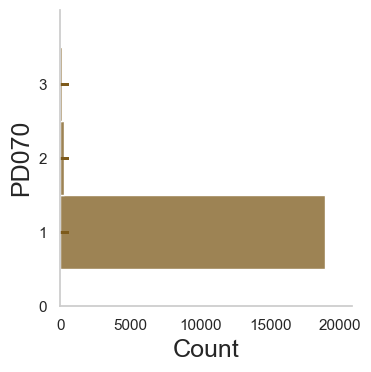

<Figure size 640x480 with 0 Axes>

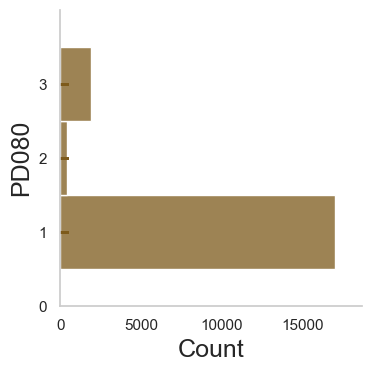

<Figure size 640x480 with 0 Axes>

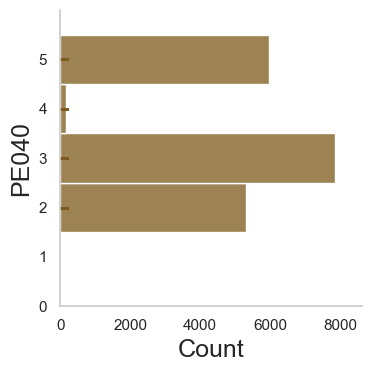

<Figure size 640x480 with 0 Axes>

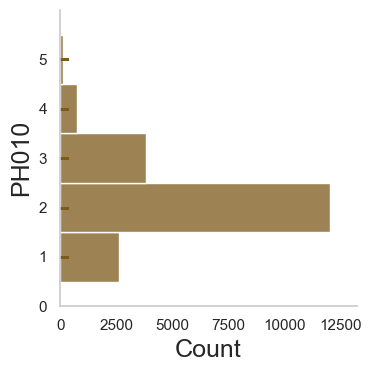

<Figure size 640x480 with 0 Axes>

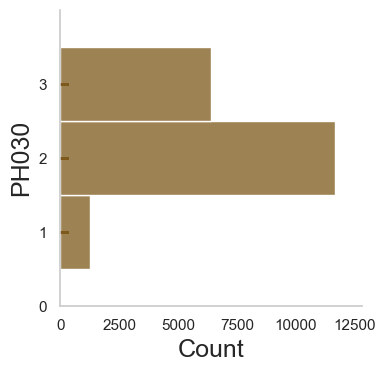

<Figure size 640x480 with 0 Axes>

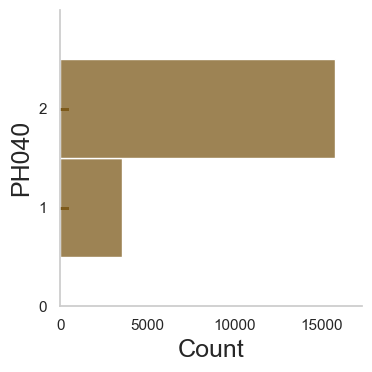

<Figure size 640x480 with 0 Axes>

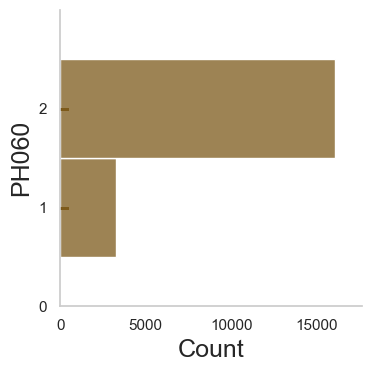

<Figure size 640x480 with 0 Axes>

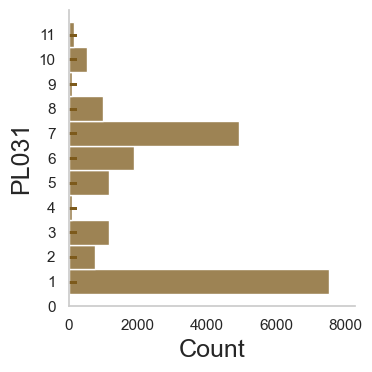

<Figure size 640x480 with 0 Axes>

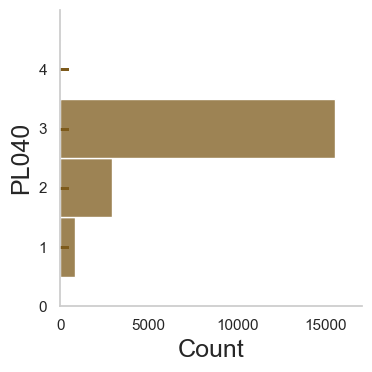

<Figure size 640x480 with 0 Axes>

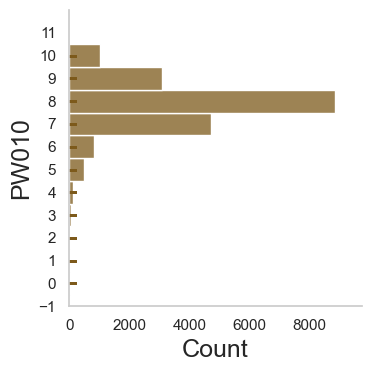

<Figure size 640x480 with 0 Axes>

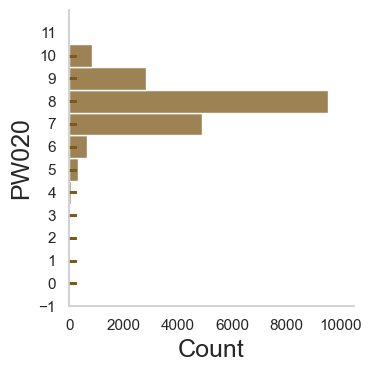

<Figure size 640x480 with 0 Axes>

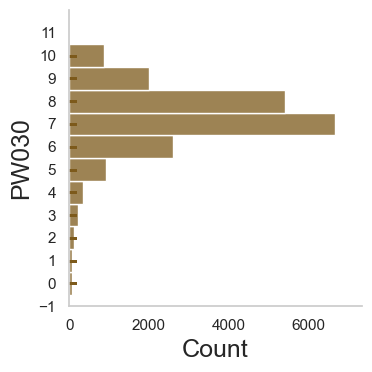

<Figure size 640x480 with 0 Axes>

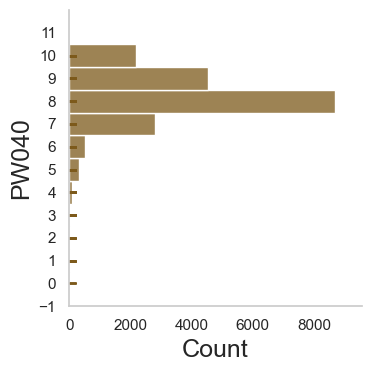

<Figure size 640x480 with 0 Axes>

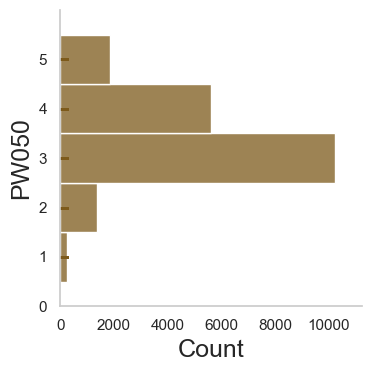

<Figure size 640x480 with 0 Axes>

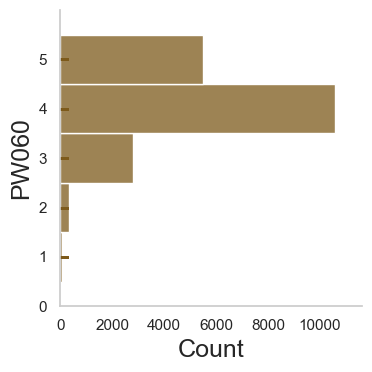

<Figure size 640x480 with 0 Axes>

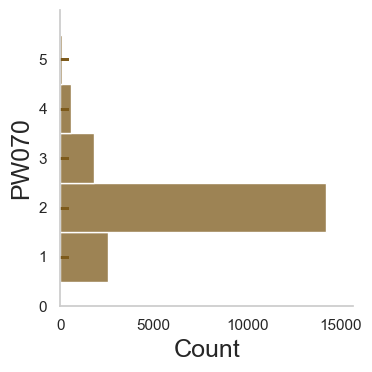

<Figure size 640x480 with 0 Axes>

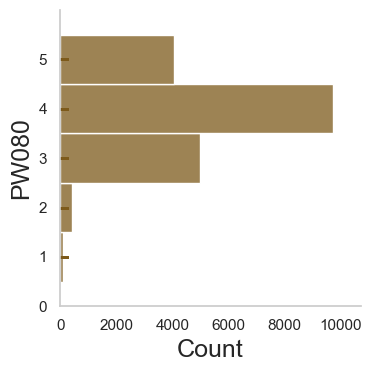

<Figure size 640x480 with 0 Axes>

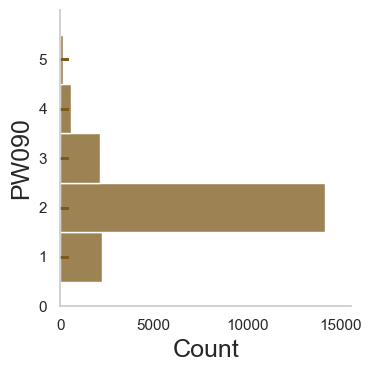

<Figure size 640x480 with 0 Axes>

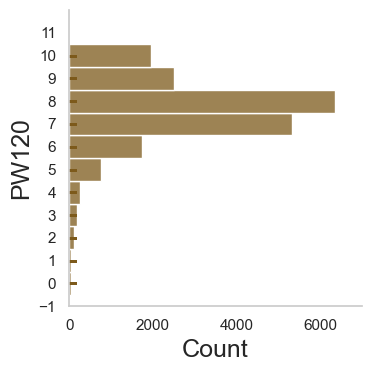

<Figure size 640x480 with 0 Axes>

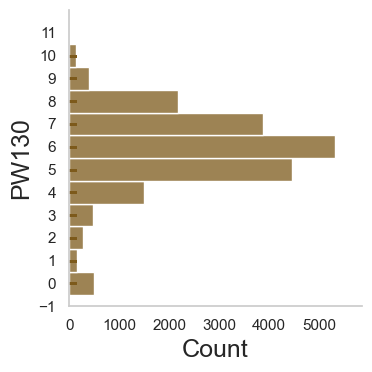

<Figure size 640x480 with 0 Axes>

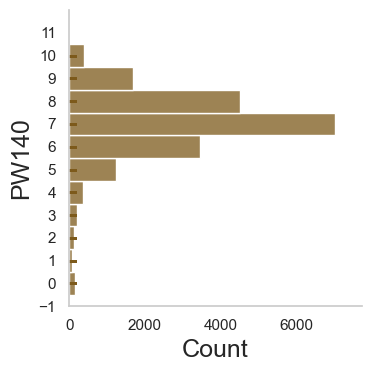

<Figure size 640x480 with 0 Axes>

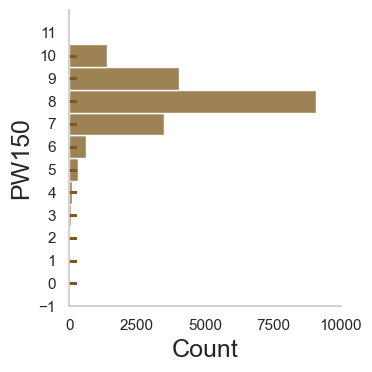

<Figure size 640x480 with 0 Axes>

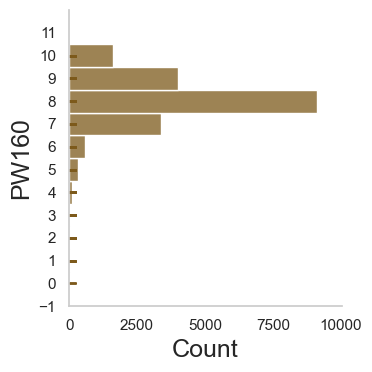

<Figure size 640x480 with 0 Axes>

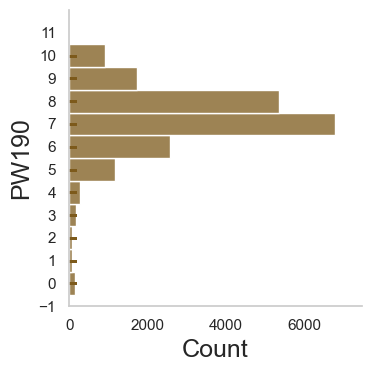

<Figure size 640x480 with 0 Axes>

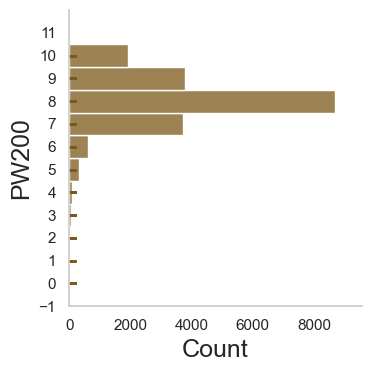

<Figure size 640x480 with 0 Axes>

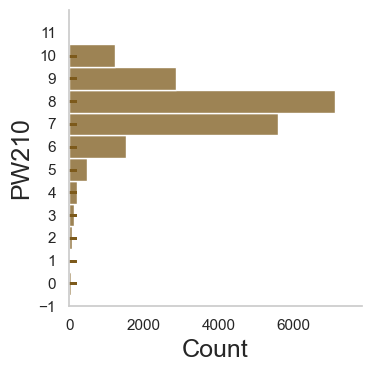

<Figure size 640x480 with 0 Axes>

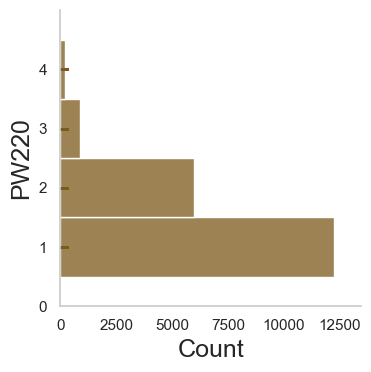

<Figure size 640x480 with 0 Axes>

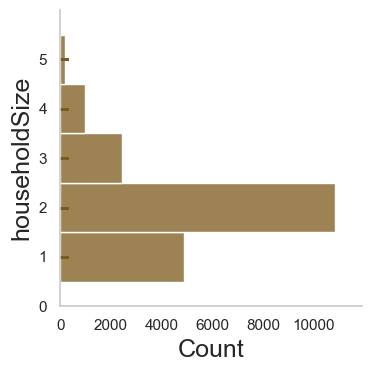

In [36]:
for col in df_o_cat.columns:
    if df_o_cat[col].value_counts().max() > 11000:
        scale_max=int(df_o_cat[col].value_counts().max())
    else:
        scale_max=11000
    if data.min_values[col] < 1:
        n_bins = int(data.max_bins[col]) + 1
        scale_min = -1
    else:
        scale_min = 0
        n_bins = int(data.max_bins[col])
    draw.plot_dist(data=df_o_cat,
                   title=col,
                   bins=n_bins + 1,
                   model_type=model_type + "_original_",
                   model=model,
                   model_name=model_name,
                   scale_min=scale_min,
                   kde=False,
                   #save=True
                   )

# Plot Single Variables

<Figure size 640x480 with 0 Axes>

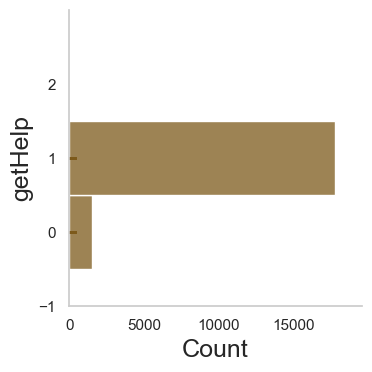

<Figure size 640x480 with 0 Axes>

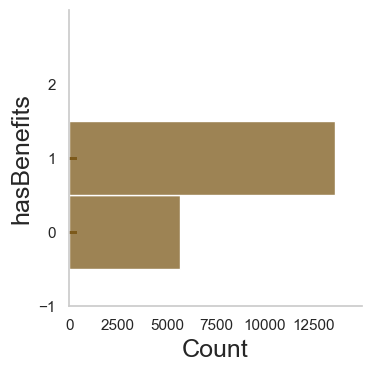

<Figure size 640x480 with 0 Axes>

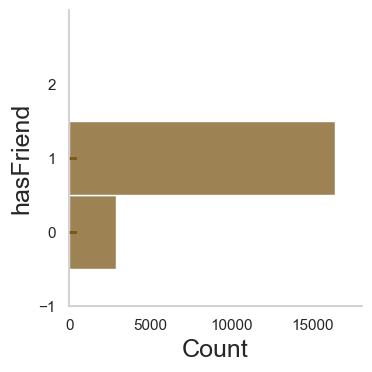

<Figure size 640x480 with 0 Axes>

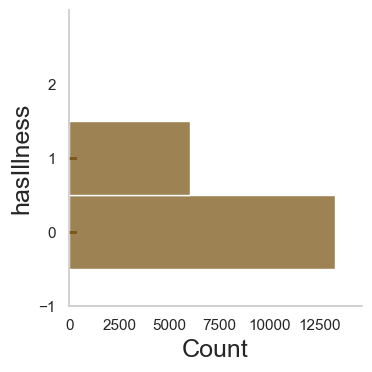

<Figure size 640x480 with 0 Axes>

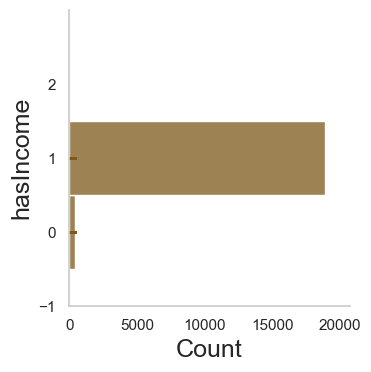

<Figure size 640x480 with 0 Axes>

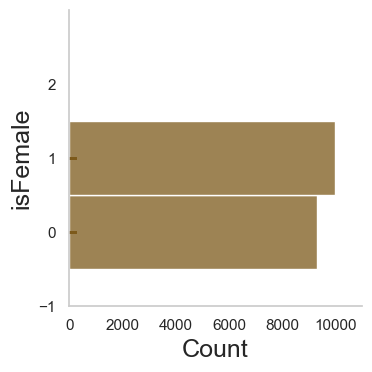

<Figure size 640x480 with 0 Axes>

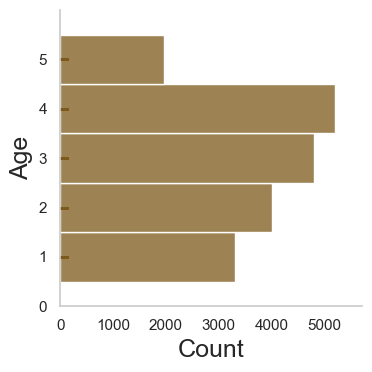

<Figure size 640x480 with 0 Axes>

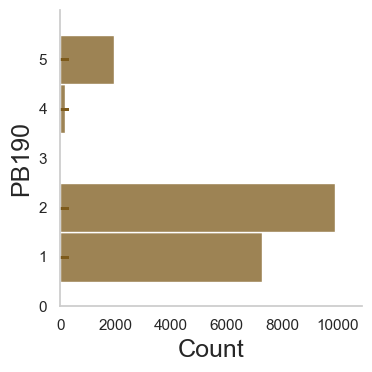

<Figure size 640x480 with 0 Axes>

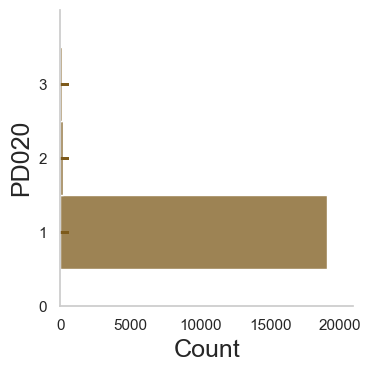

<Figure size 640x480 with 0 Axes>

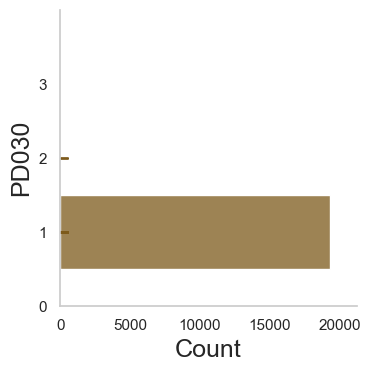

<Figure size 640x480 with 0 Axes>

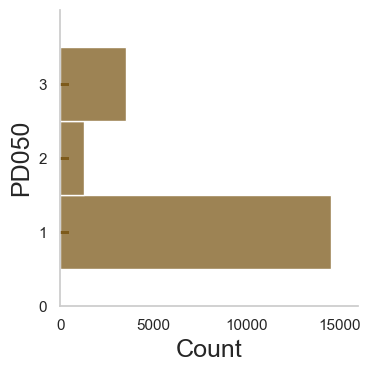

<Figure size 640x480 with 0 Axes>

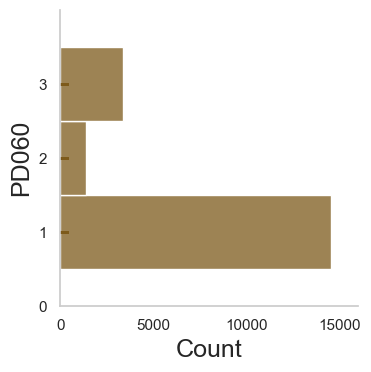

<Figure size 640x480 with 0 Axes>

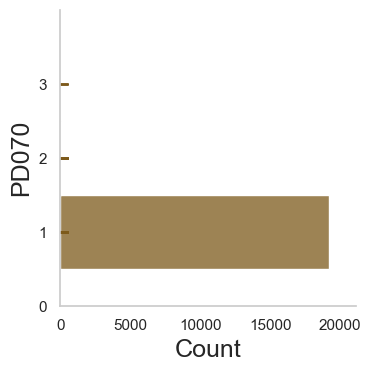

<Figure size 640x480 with 0 Axes>

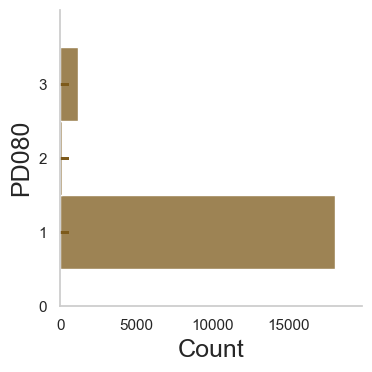

<Figure size 640x480 with 0 Axes>

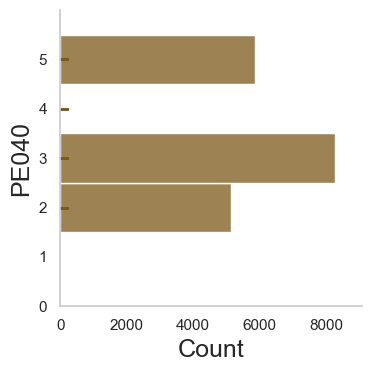

<Figure size 640x480 with 0 Axes>

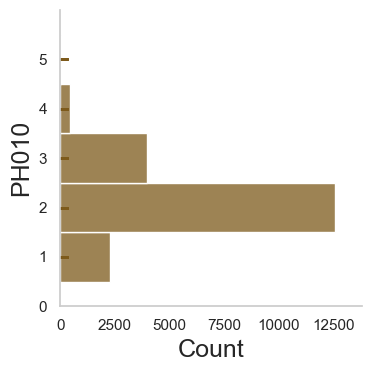

<Figure size 640x480 with 0 Axes>

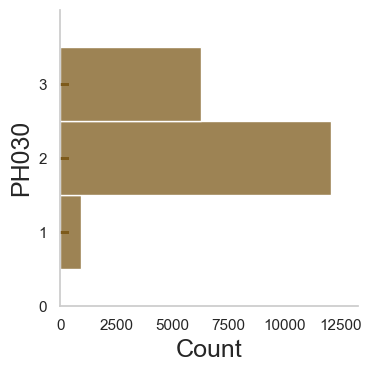

<Figure size 640x480 with 0 Axes>

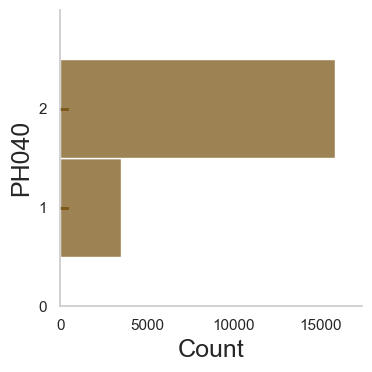

<Figure size 640x480 with 0 Axes>

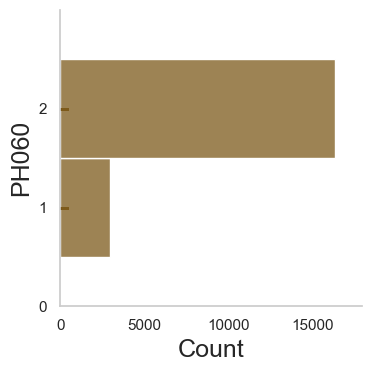

<Figure size 640x480 with 0 Axes>

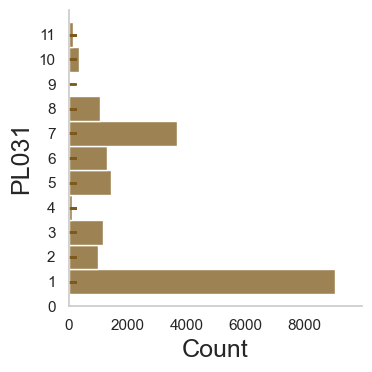

<Figure size 640x480 with 0 Axes>

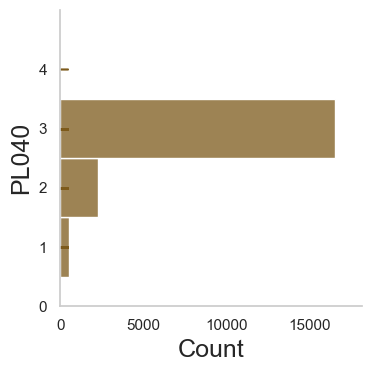

<Figure size 640x480 with 0 Axes>

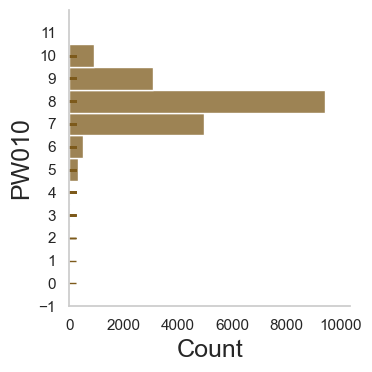

<Figure size 640x480 with 0 Axes>

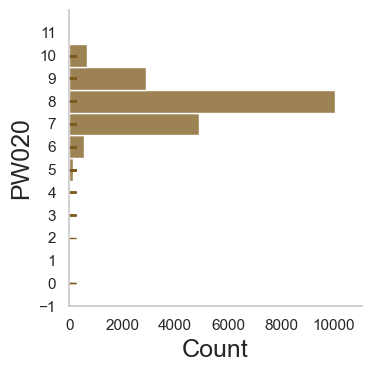

<Figure size 640x480 with 0 Axes>

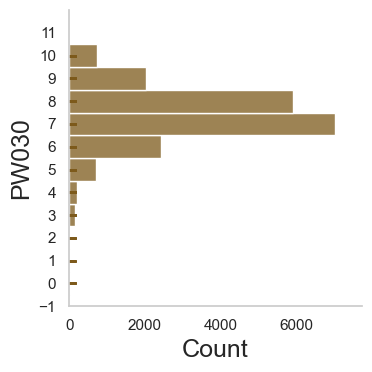

<Figure size 640x480 with 0 Axes>

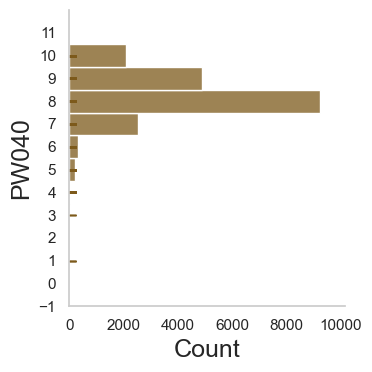

<Figure size 640x480 with 0 Axes>

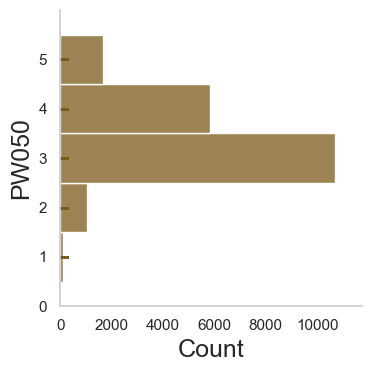

<Figure size 640x480 with 0 Axes>

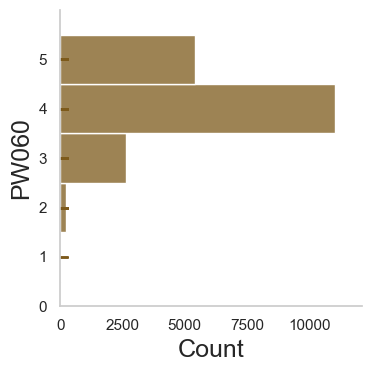

<Figure size 640x480 with 0 Axes>

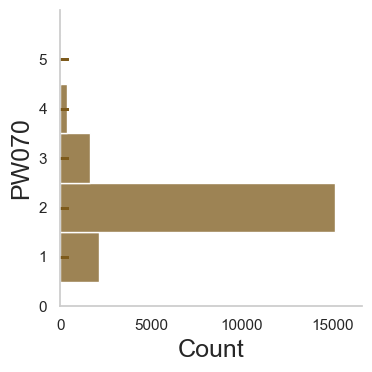

<Figure size 640x480 with 0 Axes>

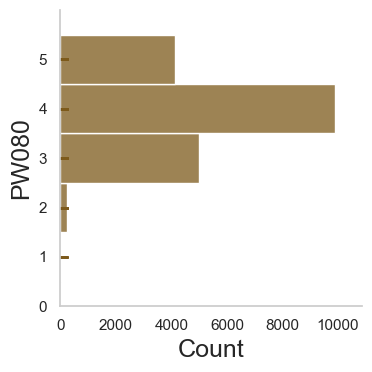

<Figure size 640x480 with 0 Axes>

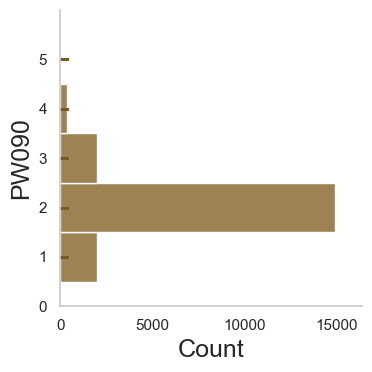

<Figure size 640x480 with 0 Axes>

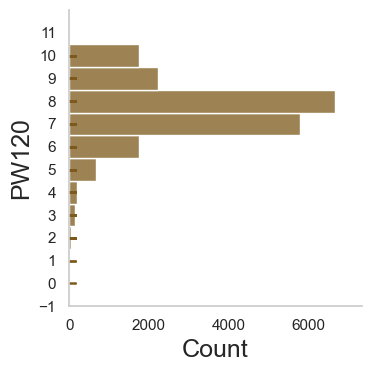

<Figure size 640x480 with 0 Axes>

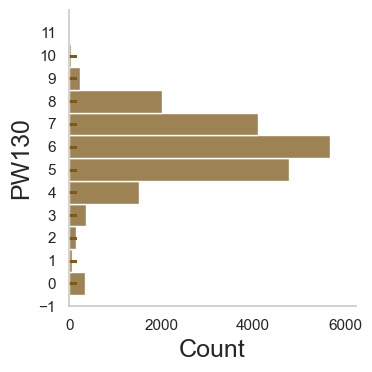

<Figure size 640x480 with 0 Axes>

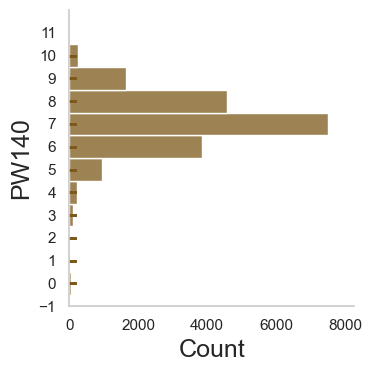

<Figure size 640x480 with 0 Axes>

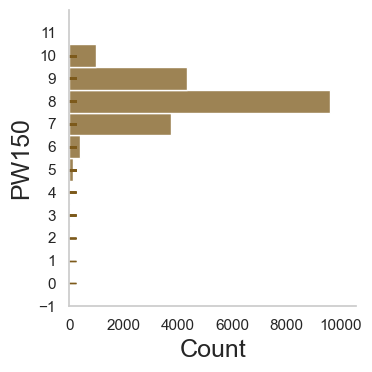

<Figure size 640x480 with 0 Axes>

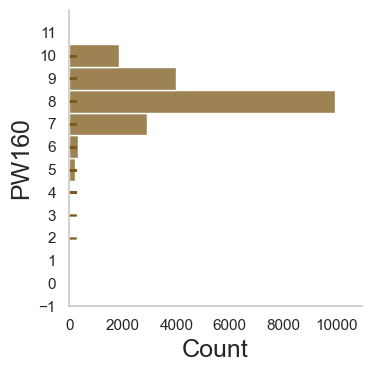

<Figure size 640x480 with 0 Axes>

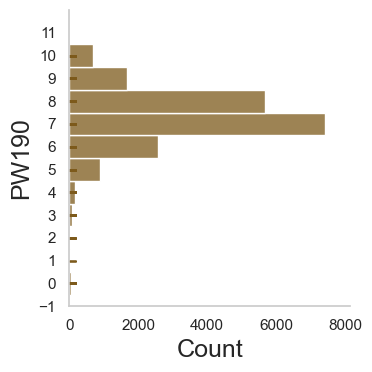

<Figure size 640x480 with 0 Axes>

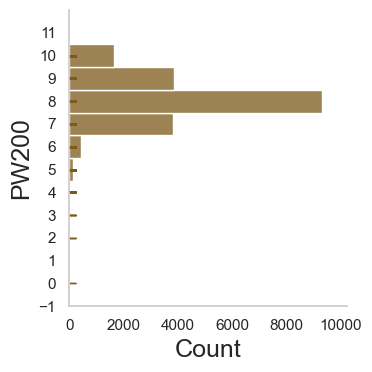

<Figure size 640x480 with 0 Axes>

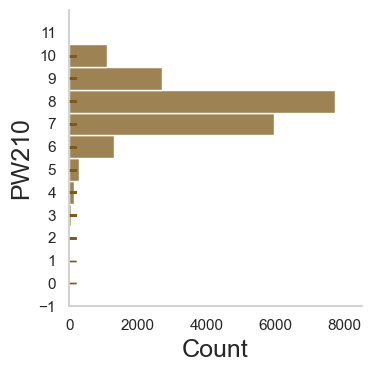

<Figure size 640x480 with 0 Axes>

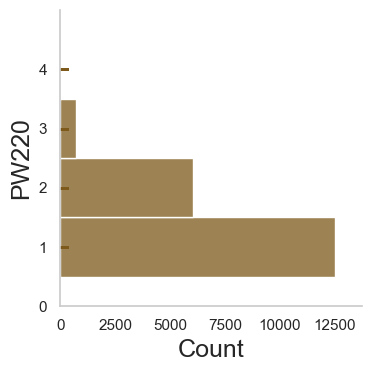

<Figure size 640x480 with 0 Axes>

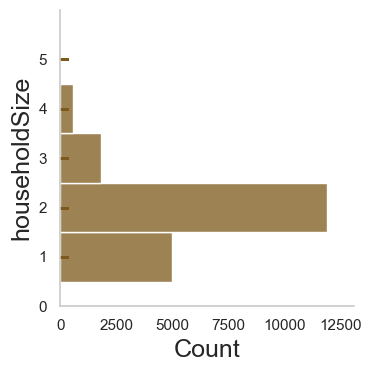

In [37]:
for col in df_s_cat.columns:
    if df_s_cat[col].value_counts().max() > 11000:
        scale_max=int(df_s_cat[col].value_counts().max())
    else:
        scale_max=11000
    if data.min_values[col] < 1:
        n_bins = int(data.max_bins[col]) + 1
        scale_min = -1
    else:
        scale_min = 0
        n_bins = int(data.max_bins[col])
    draw.plot_dist(data=df_s_cat,
                   title=col,
                   bins=n_bins + 1,
                   scale_min=scale_min,
                   #scale_max=scale_max,
                   model_type=model_type + "_synthetic_",
                   model=model,
                   model_name=model_name,
                   kde=False,
                   #save=True
                   )

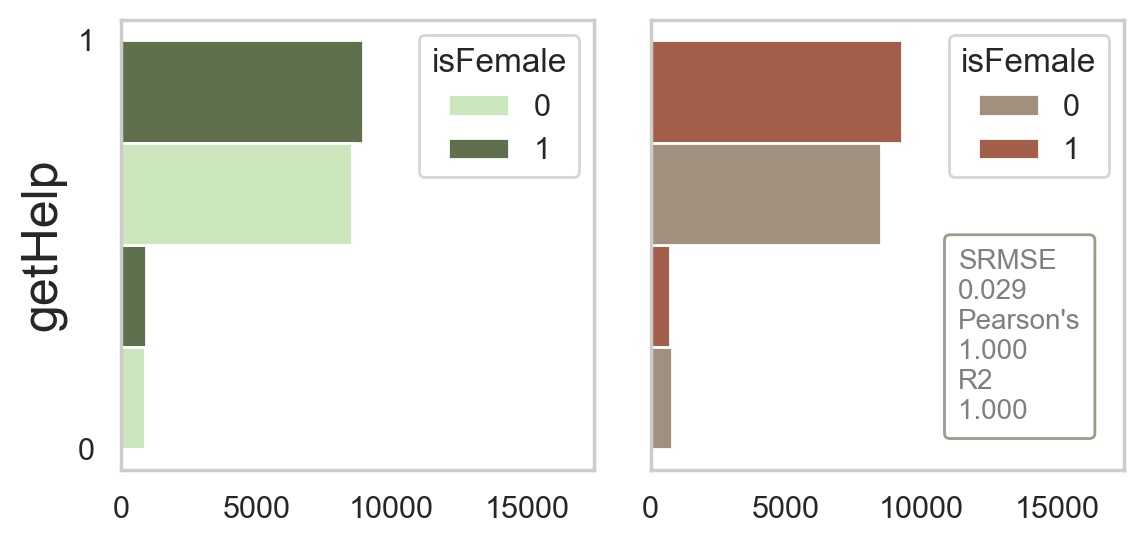

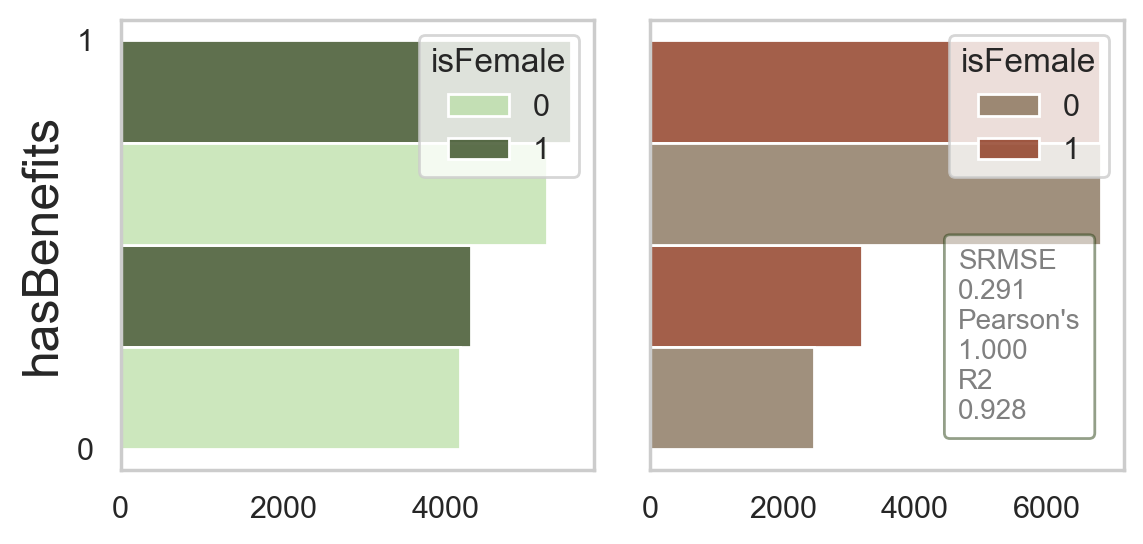

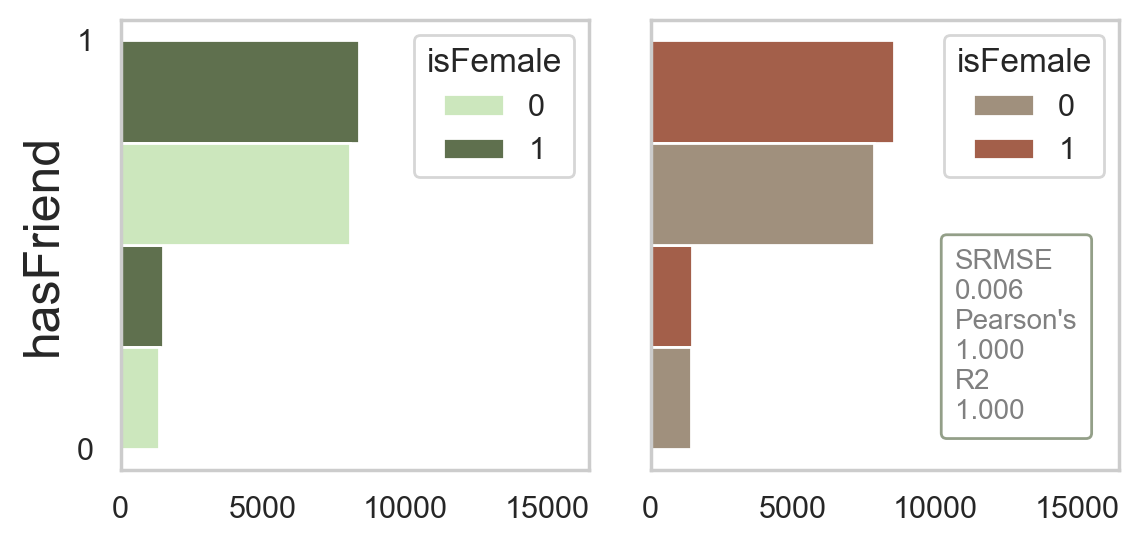

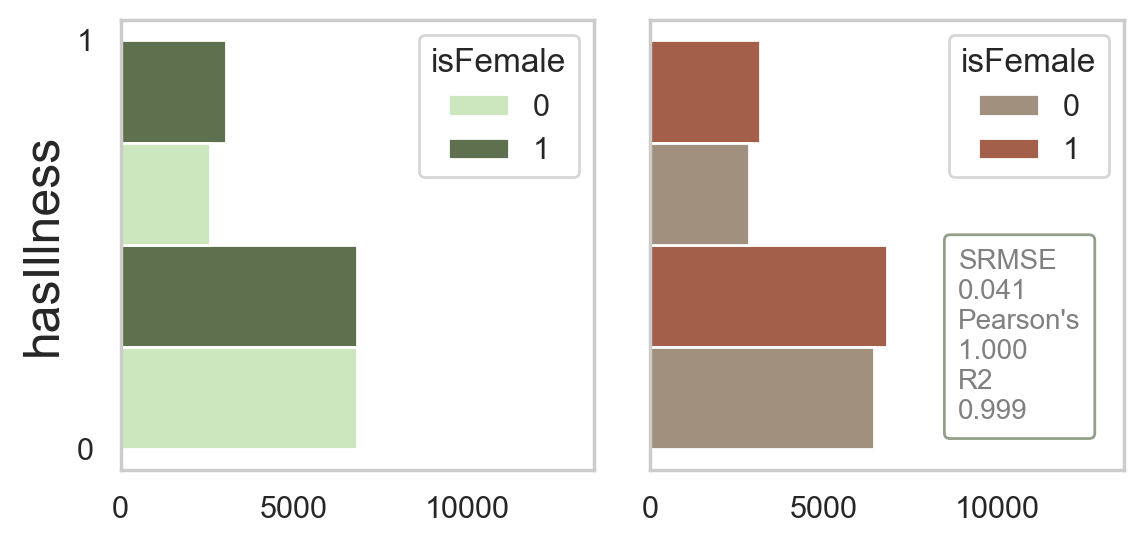

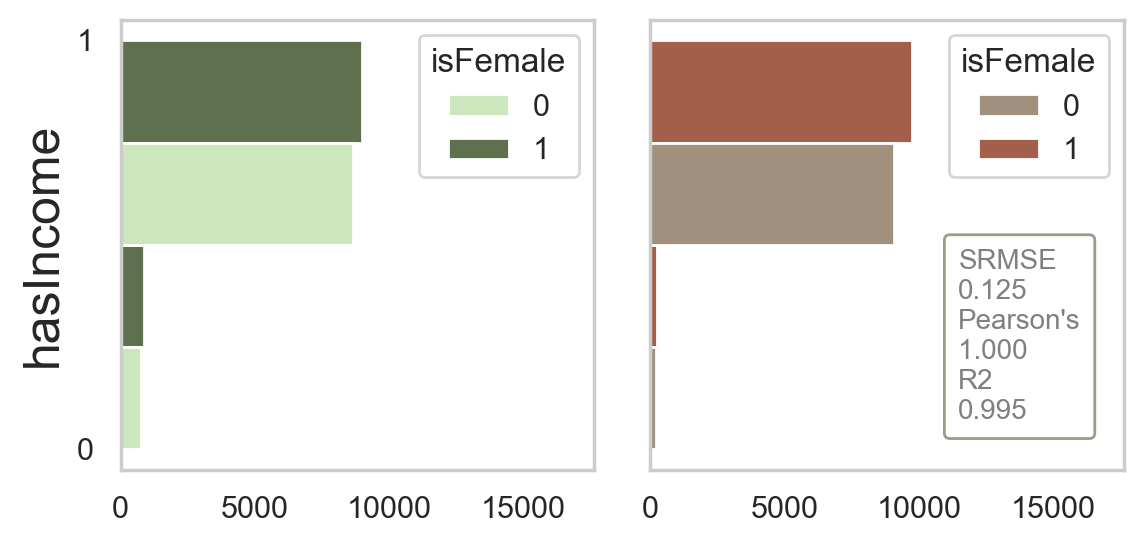

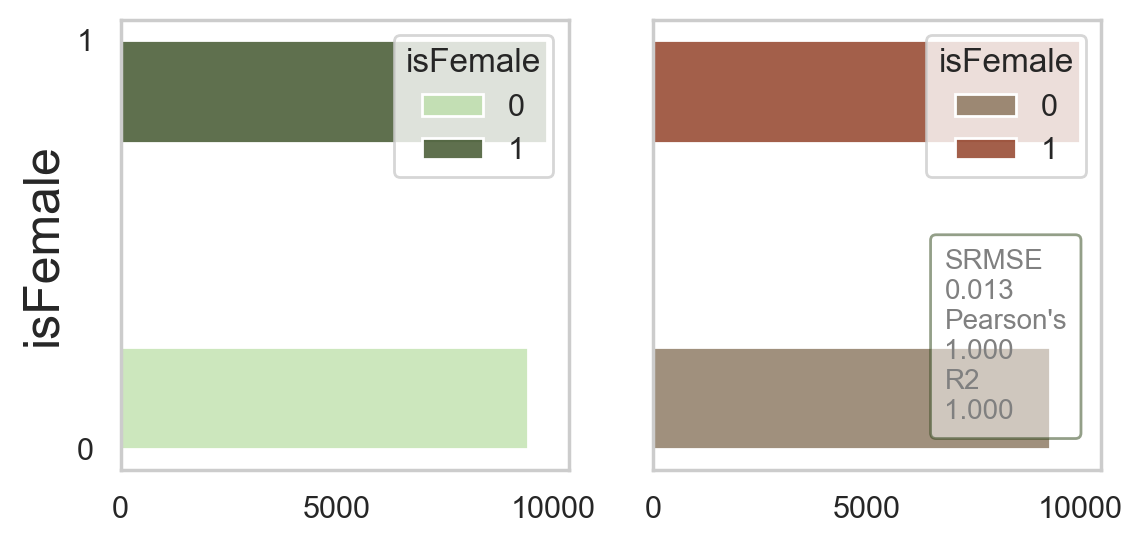

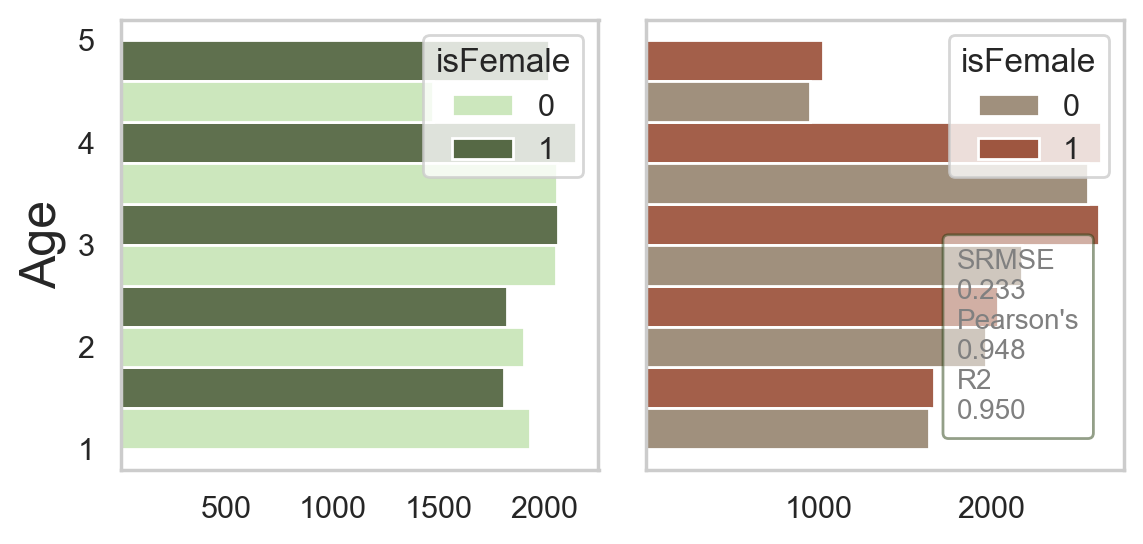

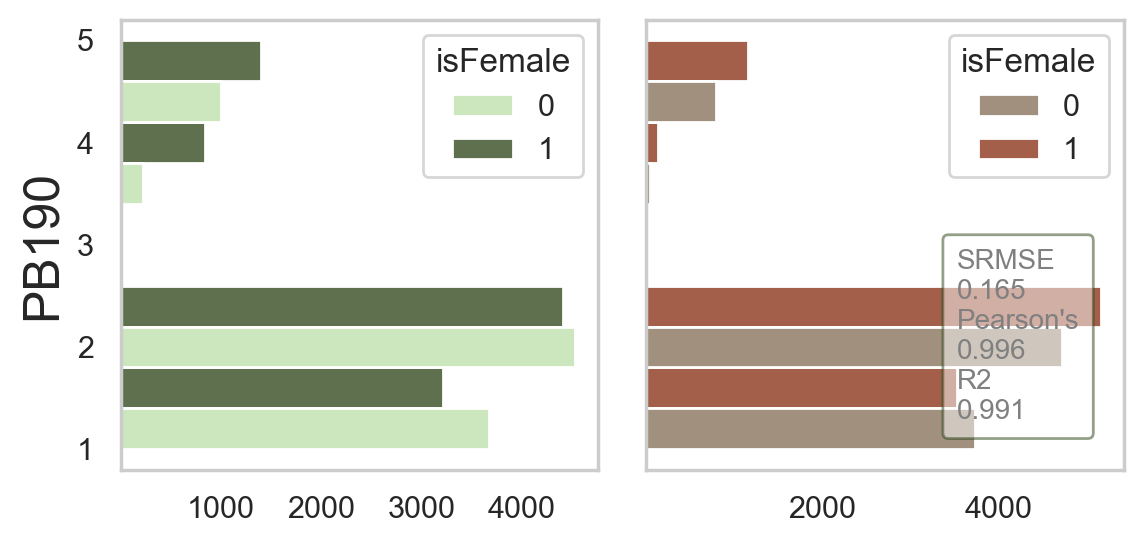

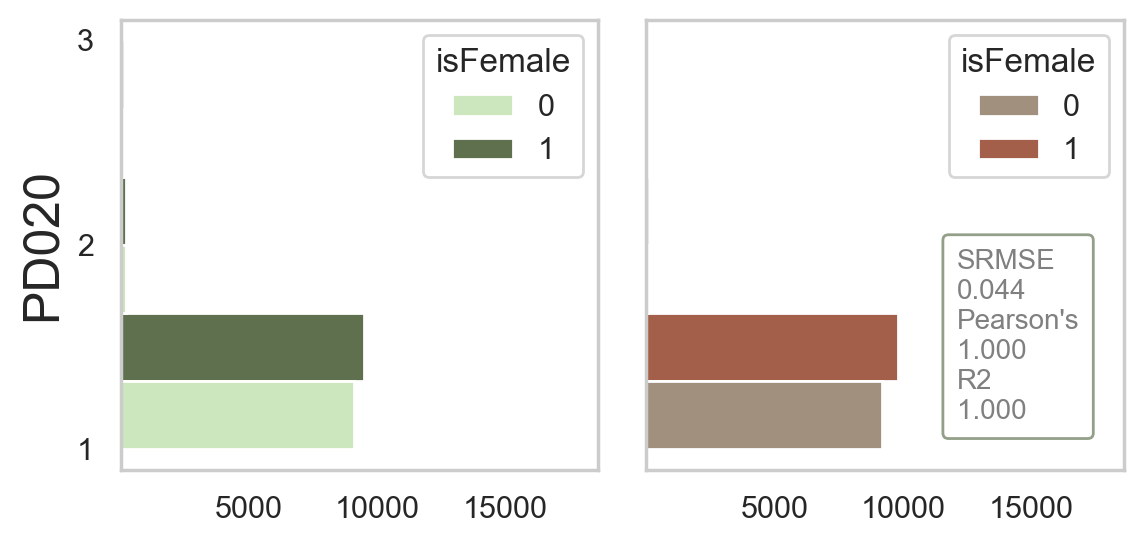

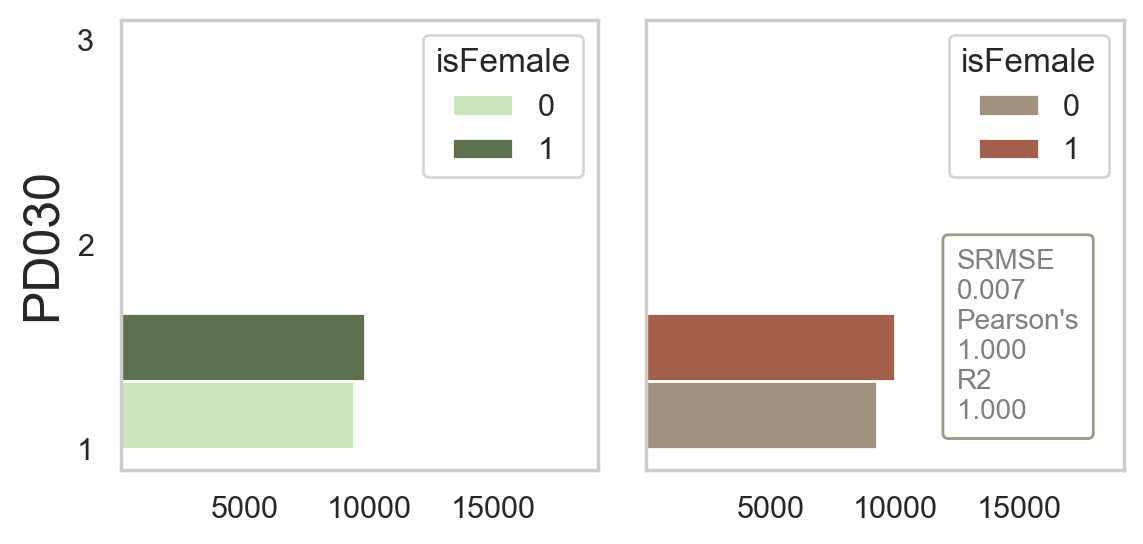

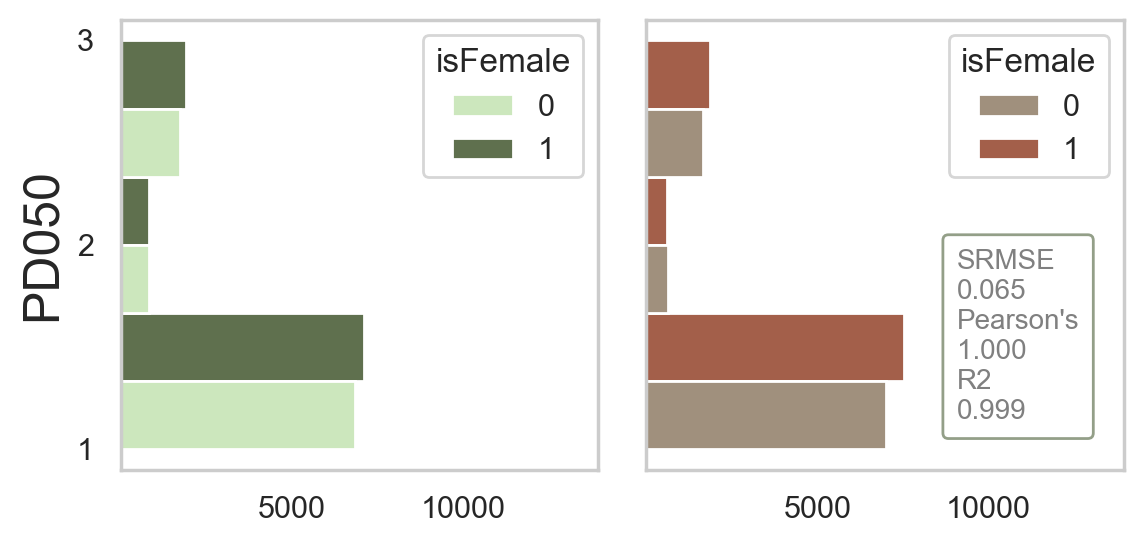

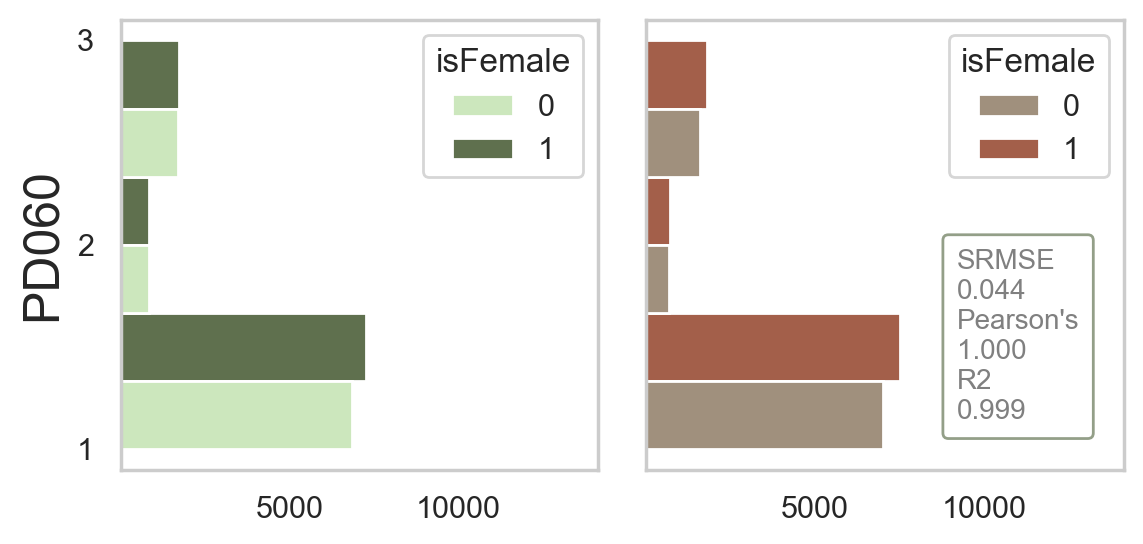

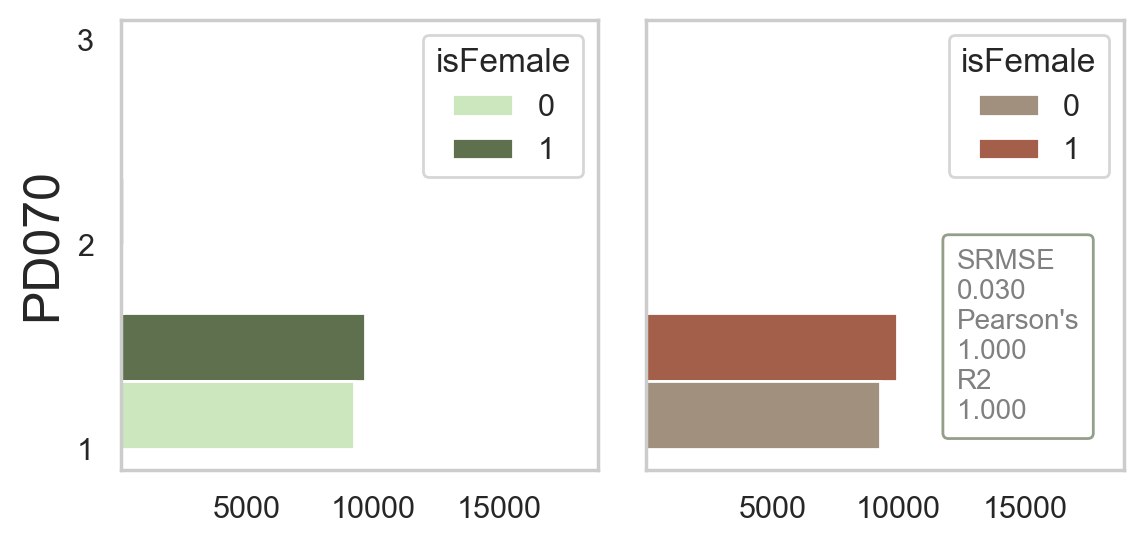

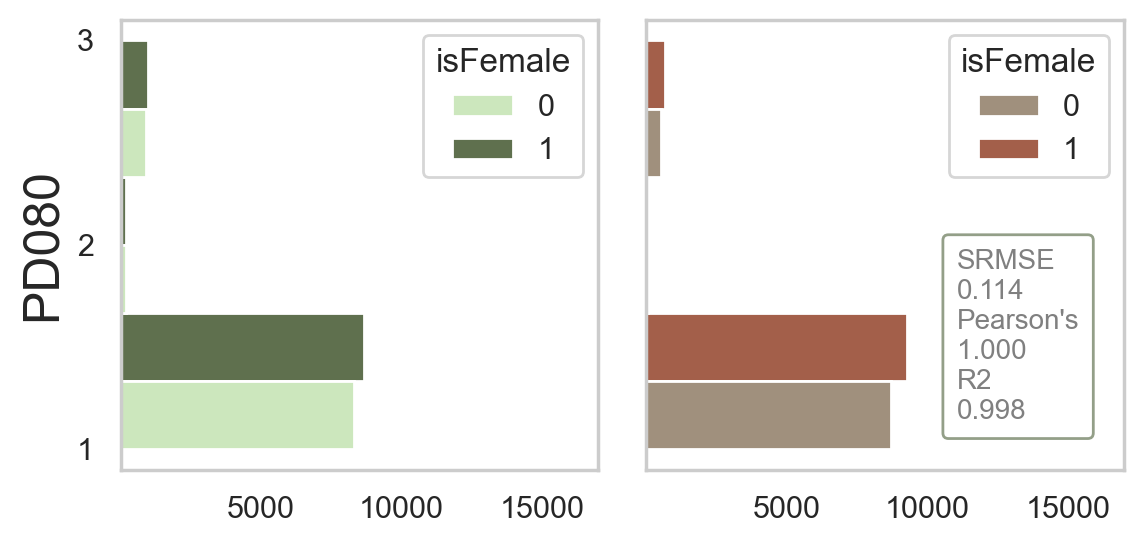

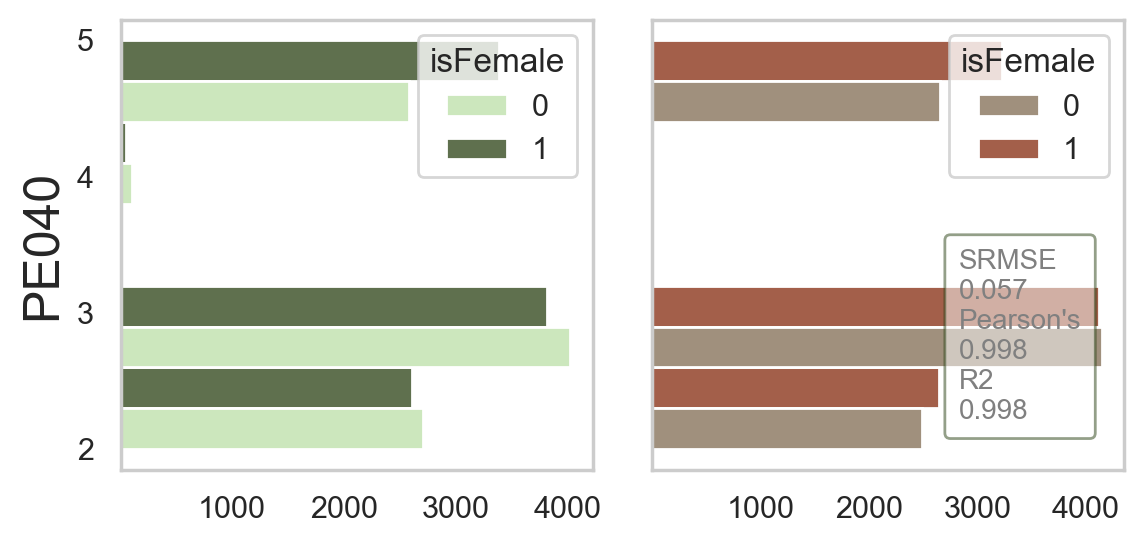

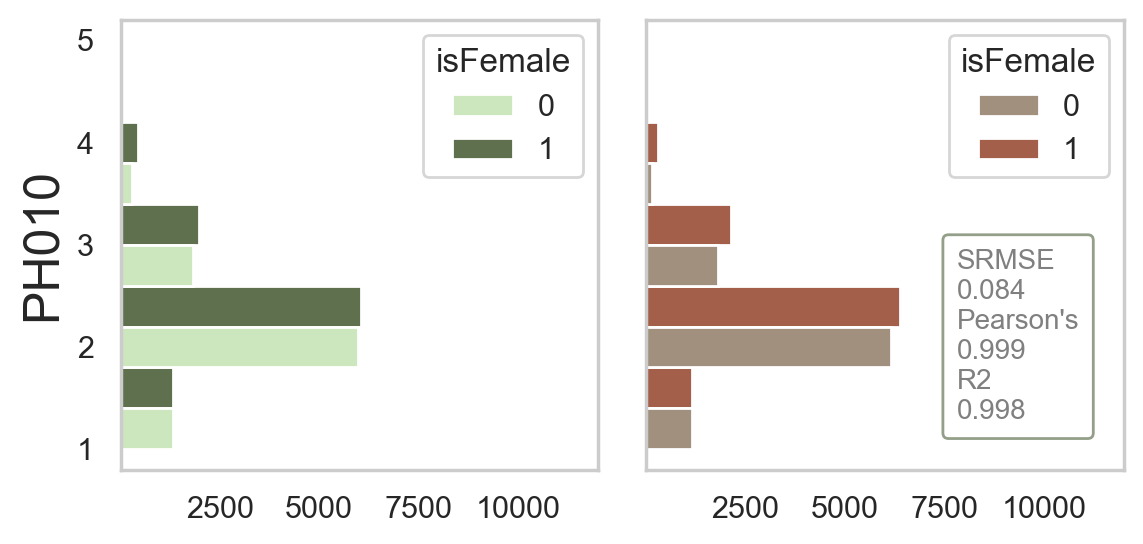

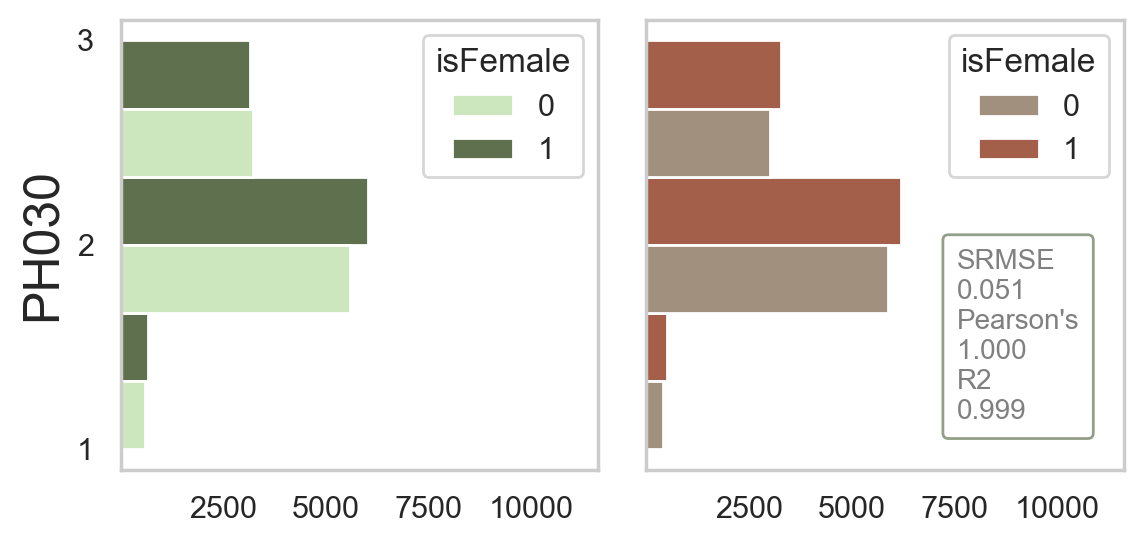

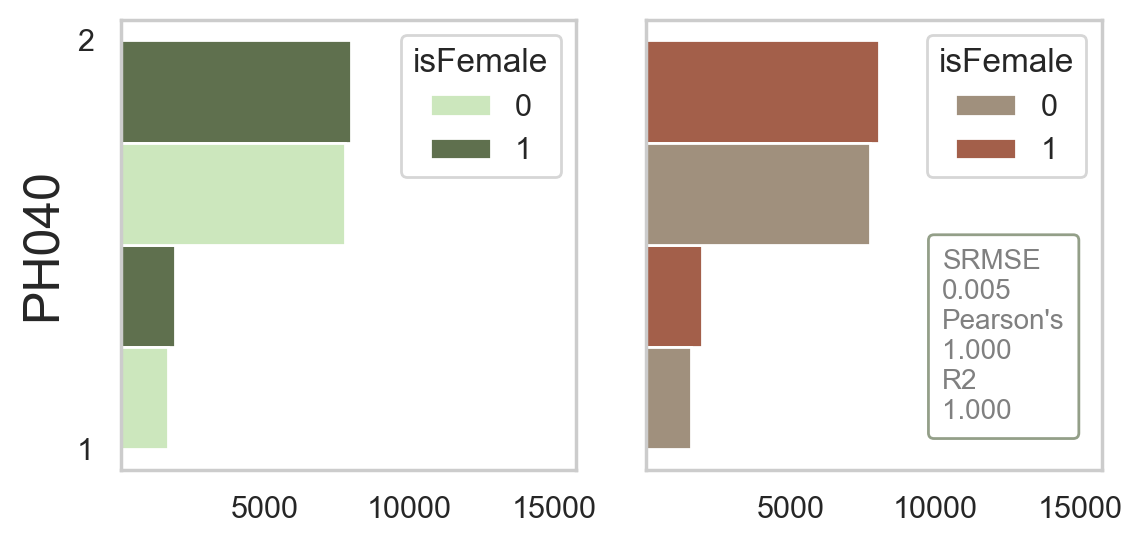

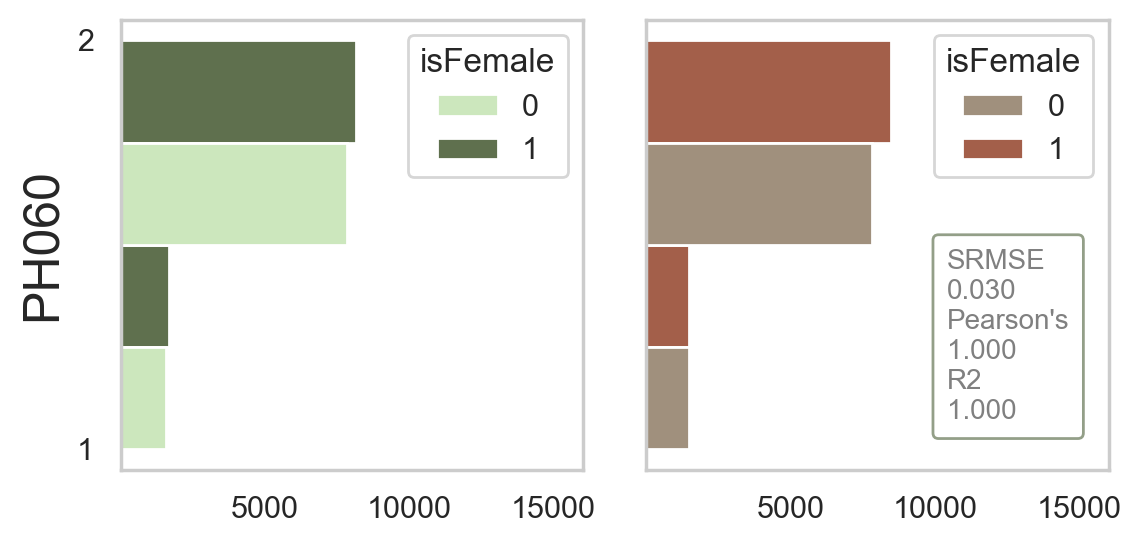

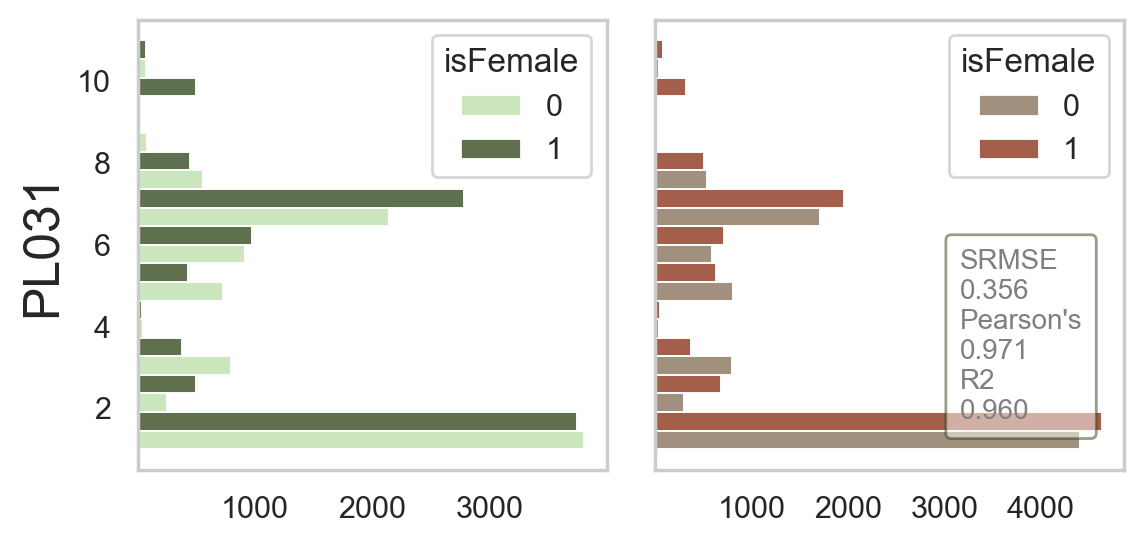

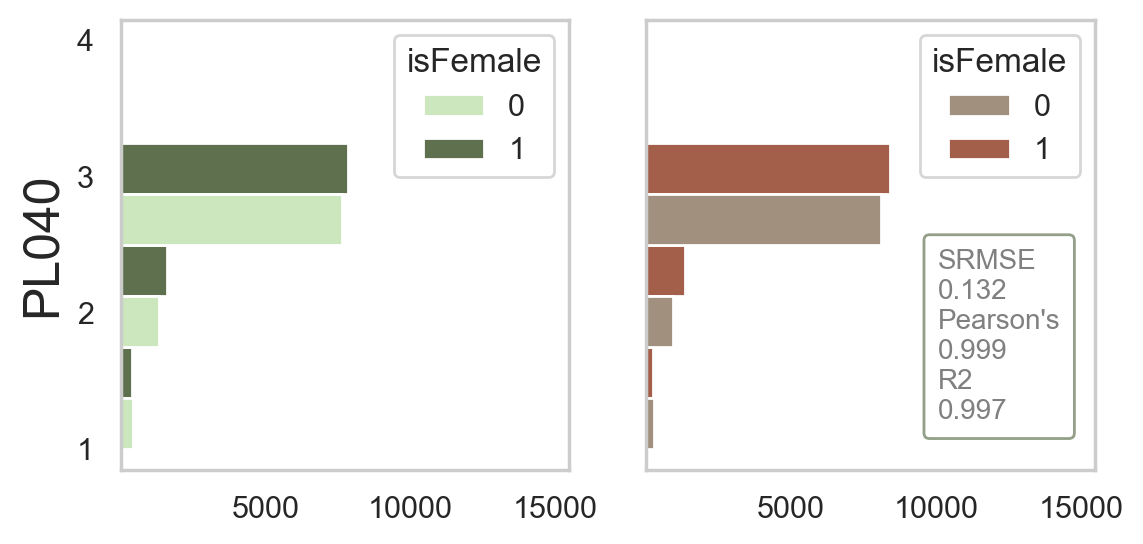

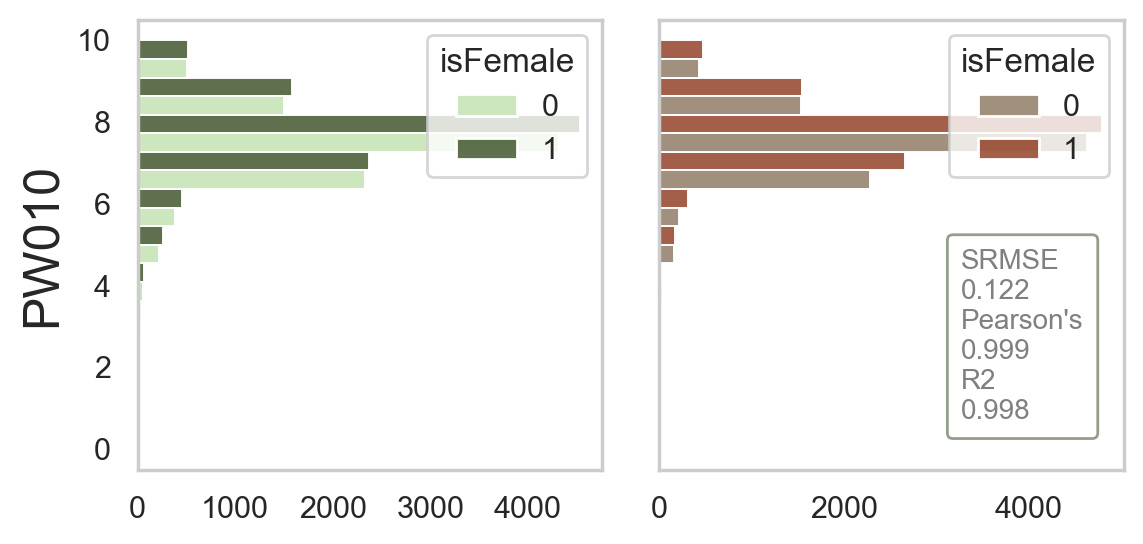

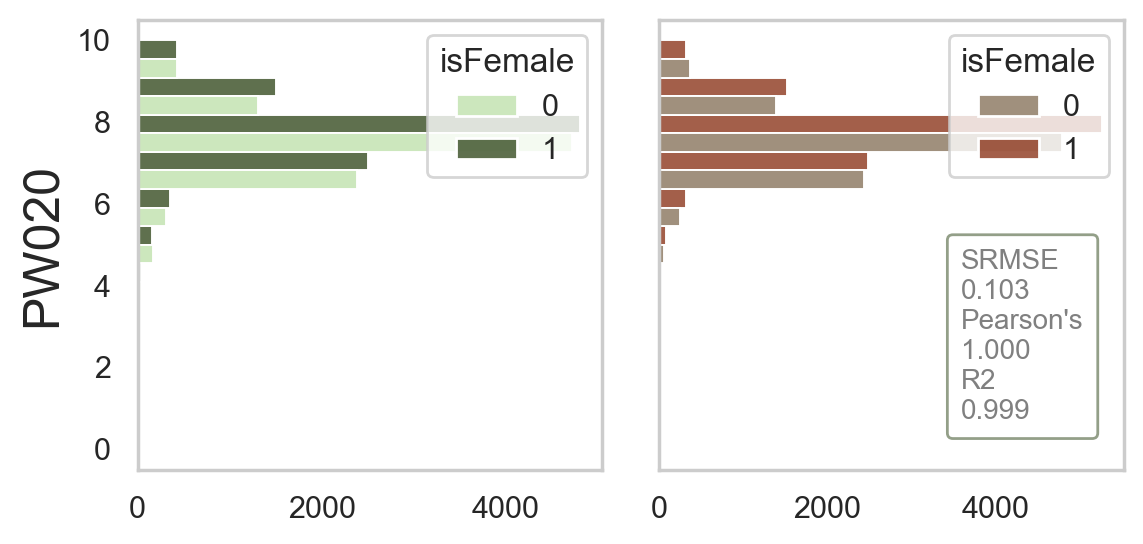

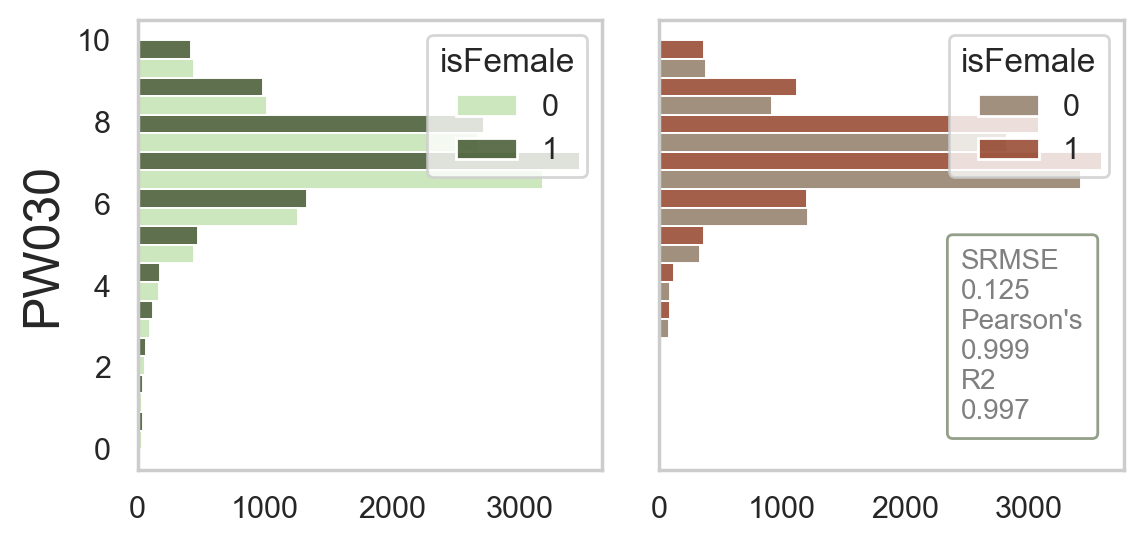

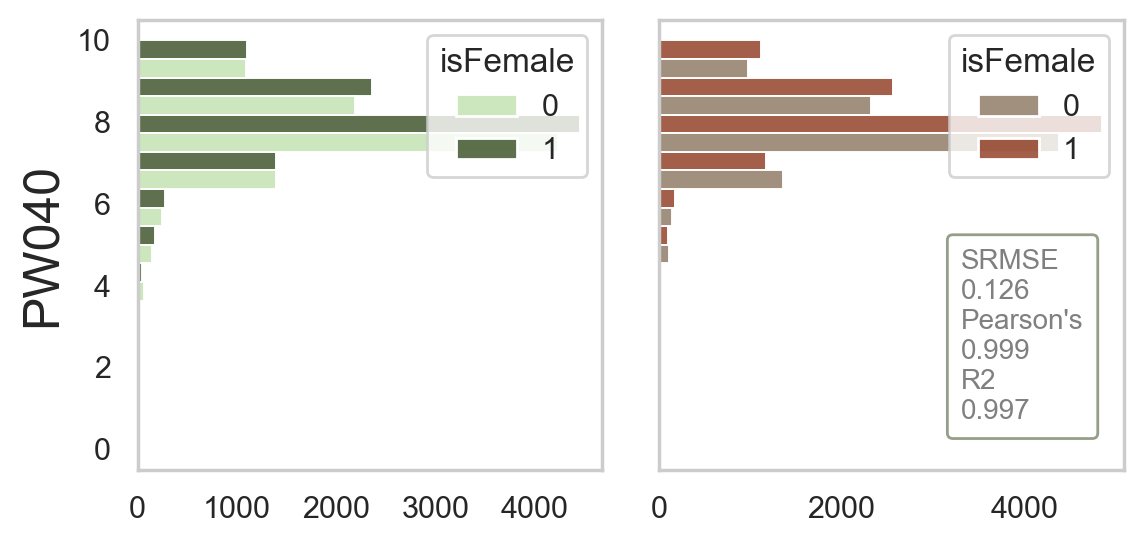

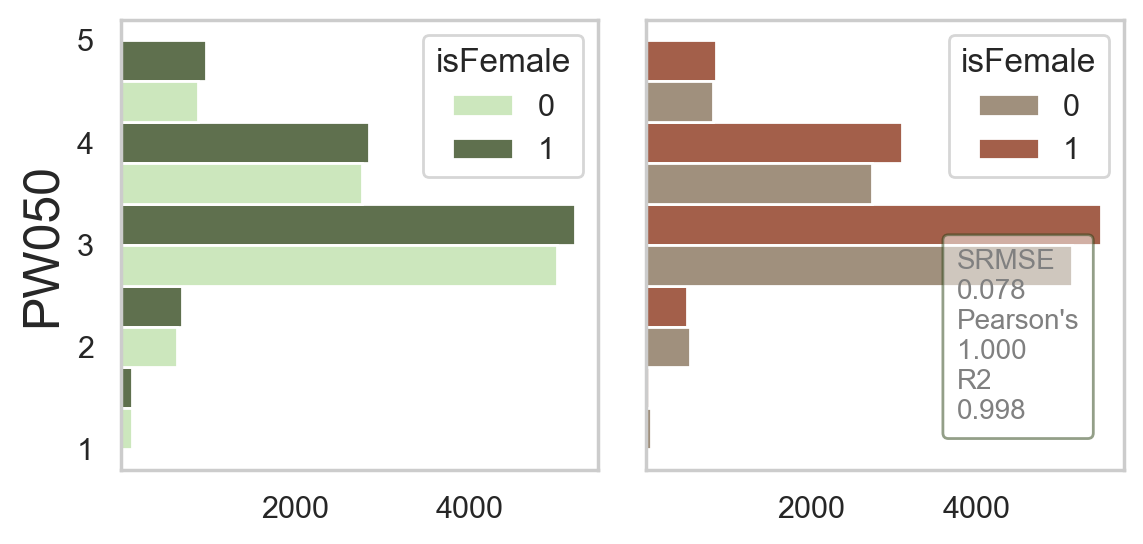

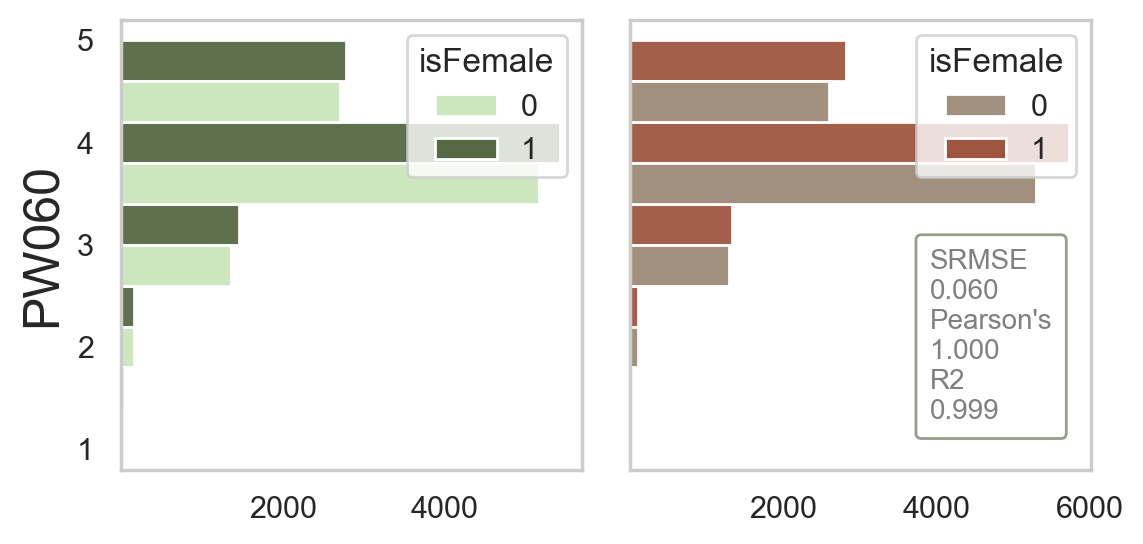

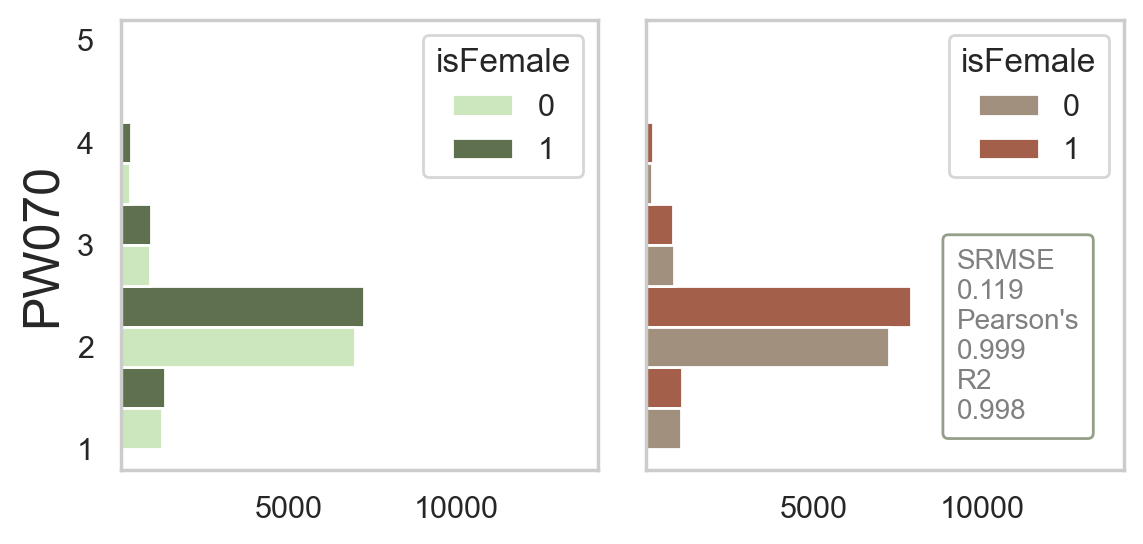

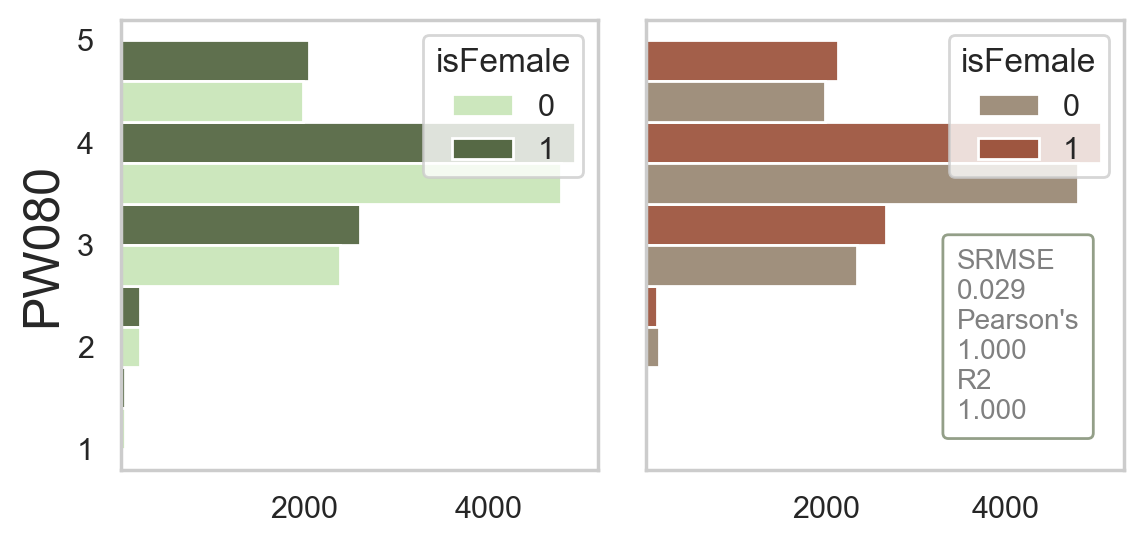

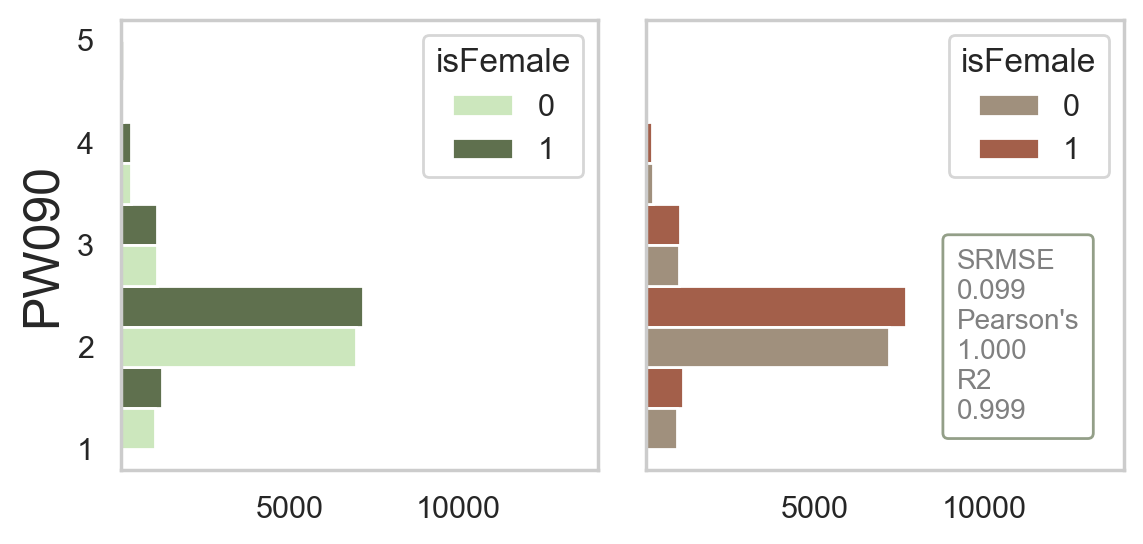

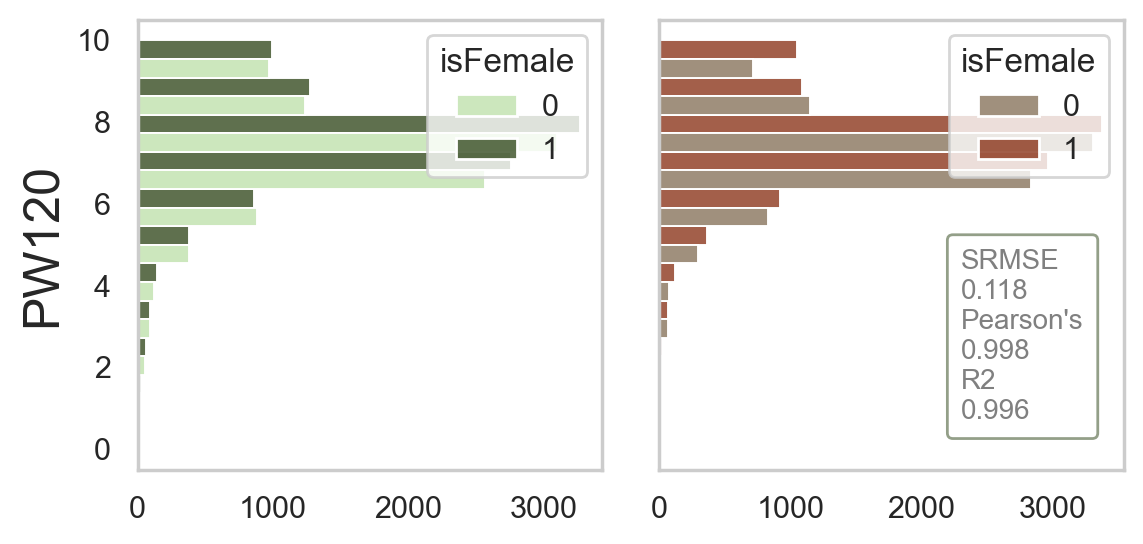

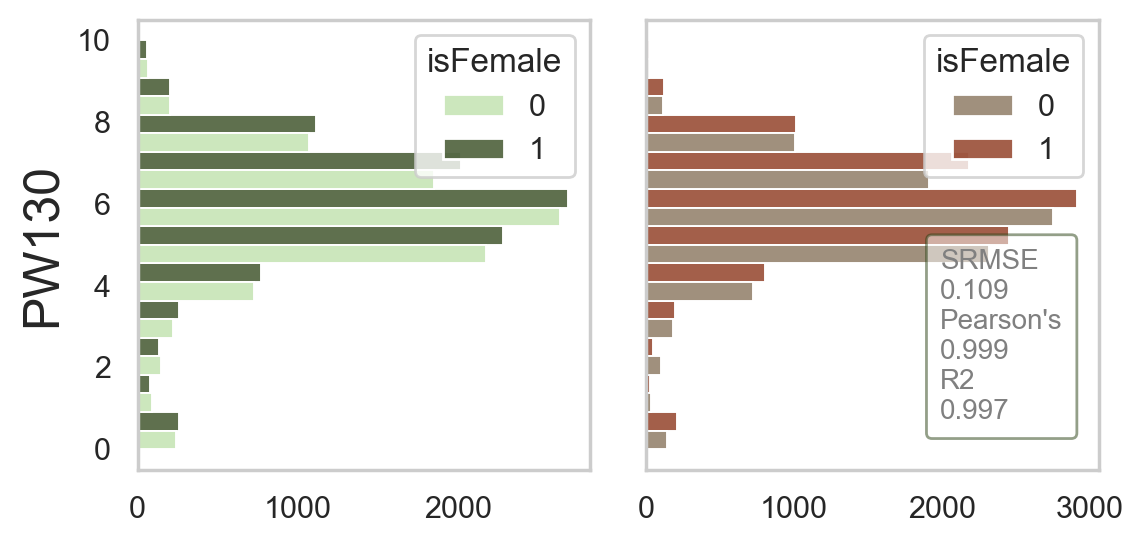

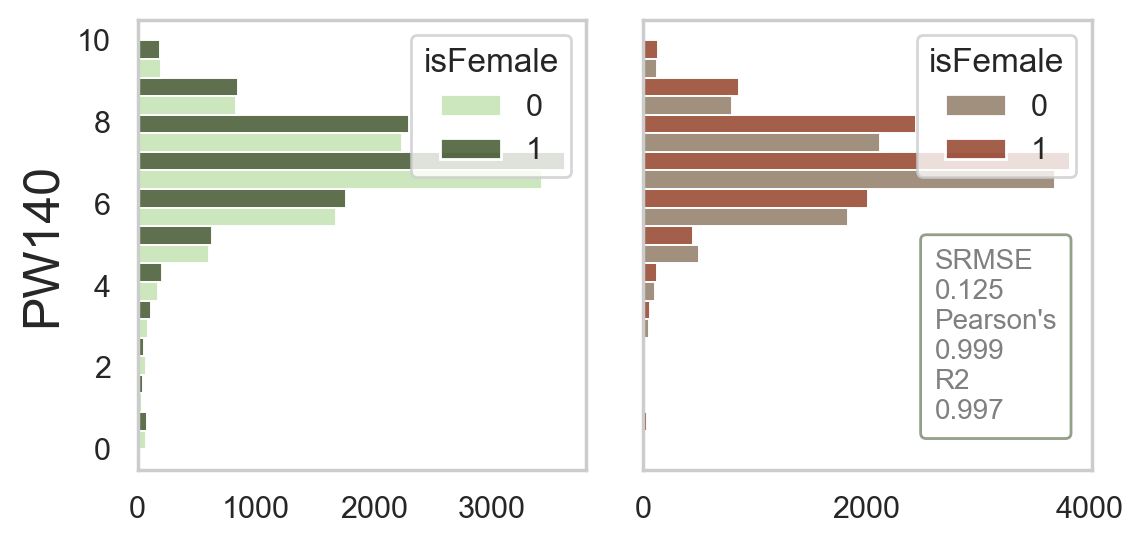

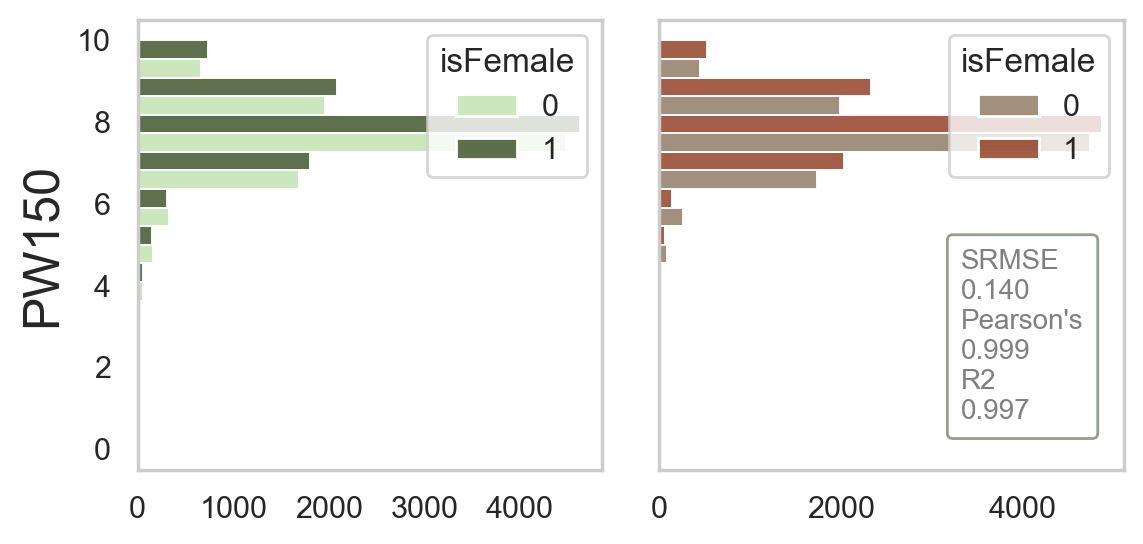

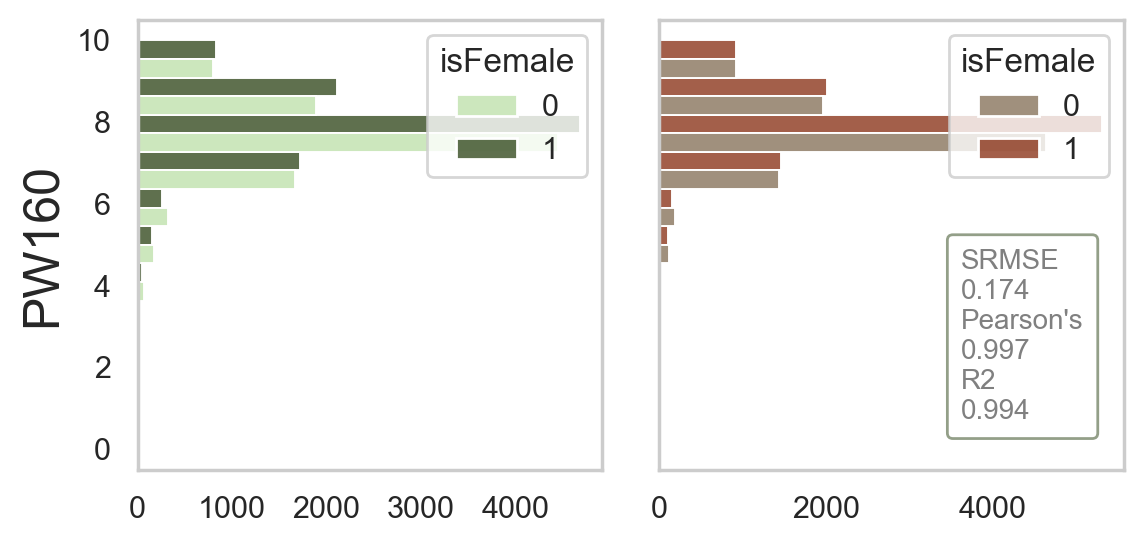

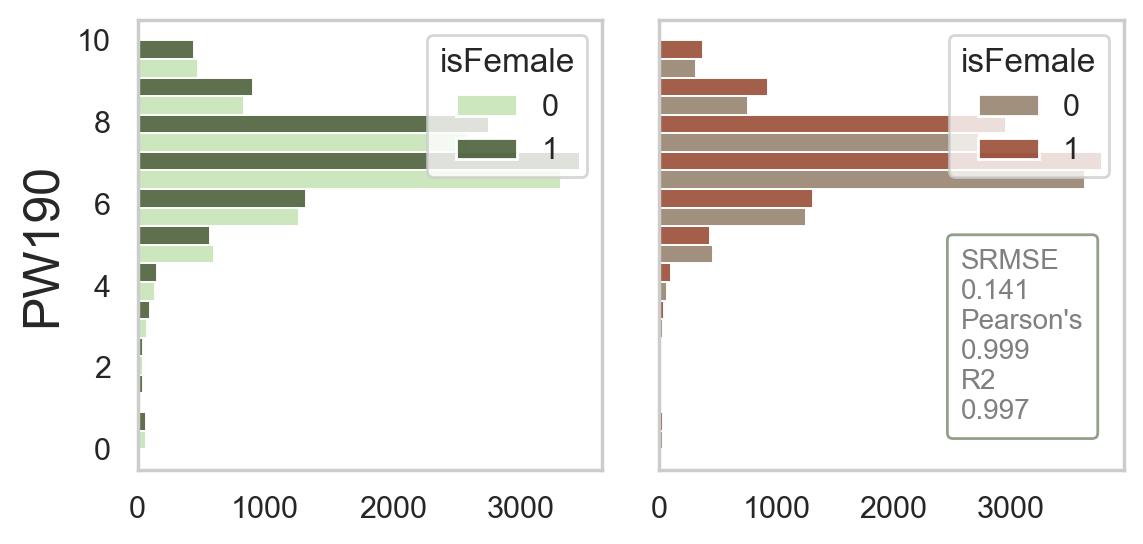

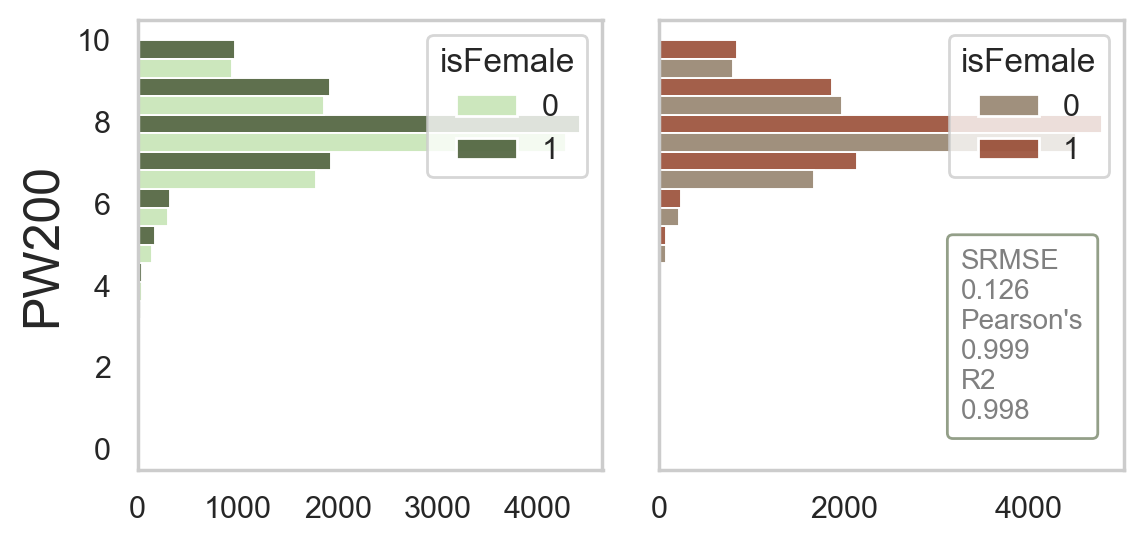

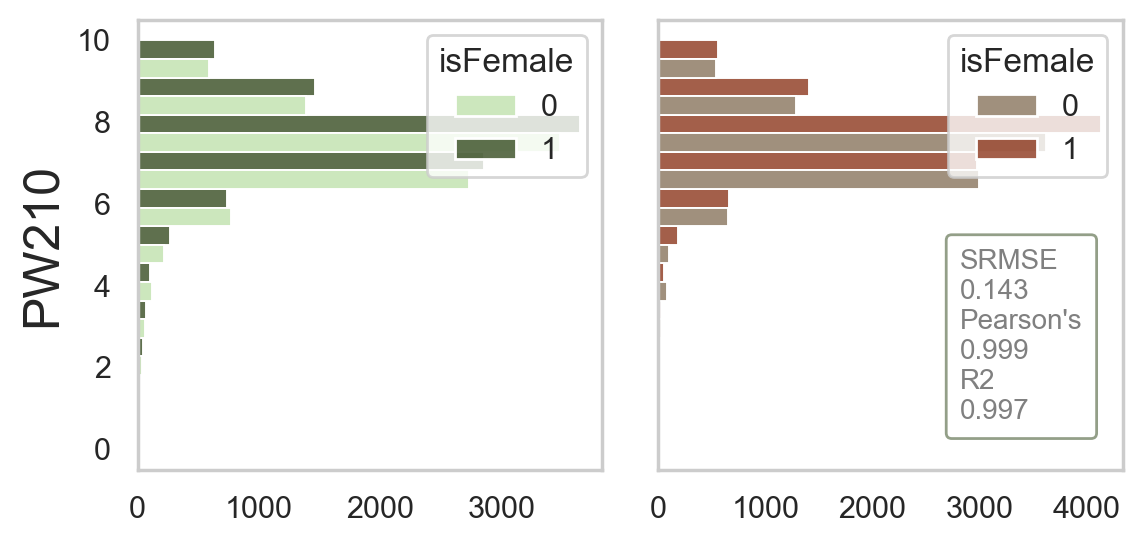

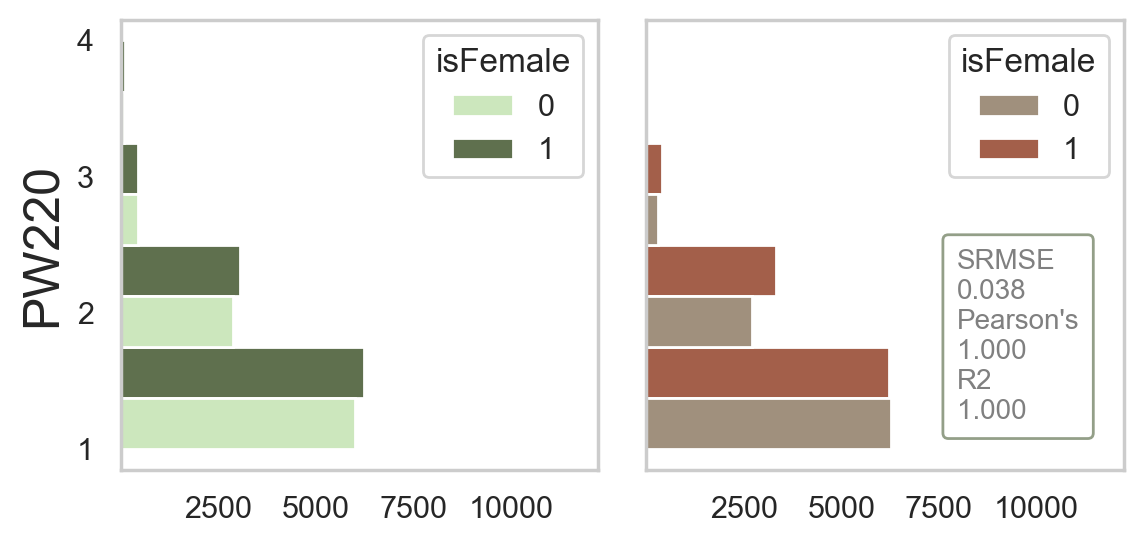

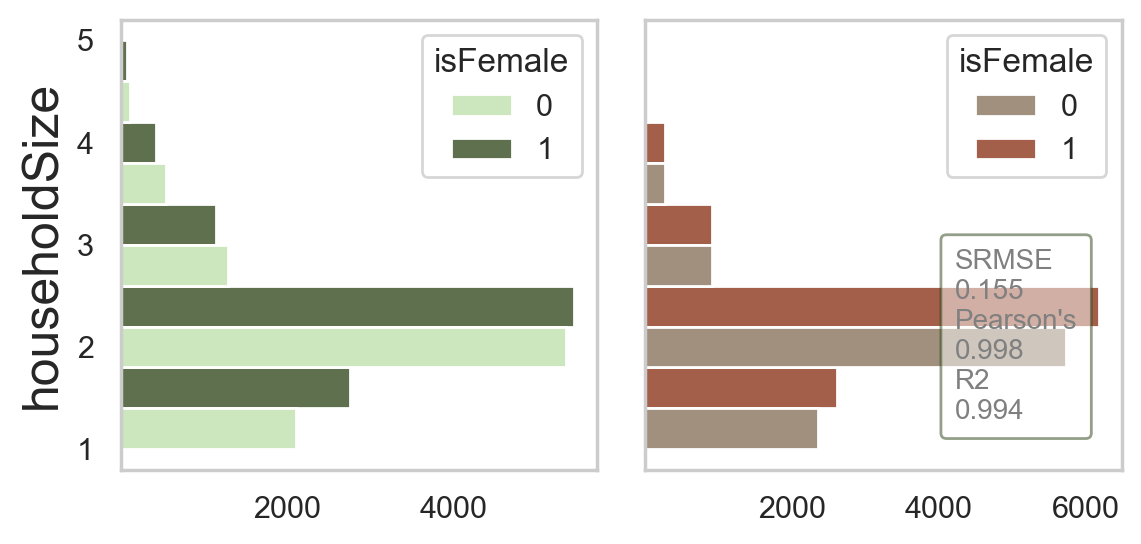

In [38]:
for col in df_o_cat.columns:
    if df_o_cat[col].value_counts().max() > 11000:
        scale_max=df_o_cat[col].value_counts().max()
    else:
        scale_max=None
    if data.min_values[col] < 1:
        n_bins = int(data.max_bins[col] + 1)
        scale_min = 0
    else:
        scale_min = 1
        n_bins = int(data.max_bins[col])
    draw.plot_two(df_original=df_o_cat, 
                  df_synthetic=df_s_cat,
                  title=col,
                  hue_value="isFemale",
                  n_bins=n_bins,
                  model_type=model_type,
                  model=model,
                  model_name=model_name,
                  scale_max=scale_max,
                  scale_min=scale_min,
                  save=save_figures
                  )